In [227]:
# This cell is simply for aesthetics
from IPython.core.display import HTML
def activate_html():
    html = HTML("""
    <style>
        #title {
          text-align: center;
          font-weight:bold
        }
        #cell {
            text-align:left
        }
        #redcell {
            text-align:left;
            color:red;
        }
        .update {
            background-color:sandybrown;
        }
        .mon {
            background-color:skyblue;
        }
        .toi {
            background-color:#ffd27f;
        }
    </style>
    """)
    return html
    

activate_html()

# Recap
Several days ago, I went through Dani's raw data files and her corresponding
Excel file, which greenlighted which variables to keep from each table.  I discovered
a few small slip ups in several tables, e.g., 
* a single value of `#NULL!` left in a table
* missing values accidentally replaced with `"-99999900.0%"` instead of `-999999` in another table
* a single somehow-overlooked missing value in 1-2 tables

We had a meeting on Dec 4, and found several more inconsistencies and misunderstandings that
we smoothed out together.  

In this notebook, I need to do 2 major things:
* add proper sections on the <b id=redcell>BISH, MON, and TOI</b> data sets
* update the demographic/clinical ingestion code from JNB `02a__KU`



# BISH & Sensors
## Sensors (MON & TOI)
We know that Udi was using the latest <b id=redcell>TOI</b> data file, `Fetal_Toitu_Physio_Features_Early_Signal_093019.csv`.  
This file can be found in
* **SharePoint**: EaSi - Documents/MBH_Maternal-Health/mbh001/Data/Udi/raw/
* **EaSi AWS**:  S3://easi-dataset/mbh001_cu_v2/data/raw/

However, in Udi's iteration (v2) of the project, he was not using new <b id="redcell">MON</b> 
data.  Instead, he was recovered <b id="redcell">MON</b> data from the "wide table" outputted
during the 4th step of Carlos' pipeline, `mbh001_Data-Wide-QC-full-data_20190614_V1.csv` (see 
JNB `01__KU` for more info).  We could technically do this as well, however we aren't sure 
how much of the data was being thrown out or going unused for various reasons...so, ideally, we
should just start from the raw <b id=redcell>MON</b> files that Carlos used.  

Carlos' sensor data can be found in:
* **SharePoint**: EaSi - Documents/MBH_Maternal-Health/mbh001/Data/Carlos/raw/sensors/
* **EaSi AWS**:  S3://easi-dataset/mbh001/cu-bish/data/raw/sensors/

There are several directories and files, but the ones used in Carlos' pipeline as specified 
by his Git repo's README are listed in the following table:

<table>
    <tr><td id="title">File in Carlos' Repo</td><td id="title">Sensor</td><td id="title">Data</td></tr>
    <tr><td id="cell">data/raw/sensors/collection_time/BISH\ FETAL\ GA\ ASSESSMENT.csv</td><td id="cell">N/A</td><td id="cell">Measurement Dates, Meta Data, etc</td ></tr>
    <tr><td id="cell">data/raw/sensors/fetal_hr/BISH_RMSSD_MONICA_052218_EARLY_SIGNAL2.csv</td><td id="redcell">MON</td><td id="cell">HR and RMMSD</td ></tr>
    <tr><td id="cell">data/raw/sensors/maternal_hr/Maternal HR XFER 052318.xlsx </td><td id="redcell"> MON </td><td id="cell"> HR Signal Features </td></tr>
    <tr><td id="cell">data/raw/sensors/movement/maternal_MVMT_monica_EHG_EHG_XFER_240s_Epochs_051818.csv </td><td id="redcell"> MON  </td><td id="cell"> MVT Signal Features </td></tr>
    <tr><td id="cell">data/raw/sensors/movement/fetal_MVMT_toitu_EDIT_240s_XFER_Signal_051818.csv </td><td id="cell"> TOI </td><td id="cell"> HR and MVT </td></tr>
</table>

For sensor data in mbh001_v3, I have copied Udi's <b id="redcell">TOI</b> data and
Carlos' <b id=redcell>MON</b> data.  I converted `maternal_hr` xlsx file to CSV. 


## BISH
There are a few BISH files -- one in Udi's project, another in Carlos', and Dani provided me
with yet another (indicated by `_DB`).  Are they all the same?

I found that both Carlos' and Udi's BISH files contain 12384 lines, while DB's contains 12383.

```
cat BISH\ FETAL\ GA\ ASSESSMENT_Carlos.csv | wc -l
    12384
cat BISH\ FETAL\ GA\ ASSESSMENT_Udi.csv
    12384
cat BISH\ FETAL\ GA\ ASSESSMENT_DB.csv
    12383
```

I noticed that DB actually shuffled around the columns in her file, so this could help
explain things: ... To make analysis easier, I looked more closely in Python...

--------------------------------------
**CONCLUSION**: below I find that all the BISH files contain 12,383 records with 6,558 unique PATIDs,
so Dani's file is fine to use / no need to further understand differences IMHO.

-----------------------------------

<div class="update">
    <b>UPDATE (Dec 6)</b>: 
    <p> Yesterday, while going through the BISH, TOI, and MON files, I realized
        that it is not 100% necessary to use the BISH file.  The TOI and MON data technically contain
        "Fx" information (weekly GA ranges), so assuming we can trust how the files were put together,
        we can just use that information to inform what variables are allowed in a given model (e.g.,
        for a 32wk preterm model, both F1 and F2 data can be used, while only F1 data can be used for
        a 28wk preterm model). </p>
    <p> Having said that, it is <b>important</b> to understand that I do not fully trust 
        the BISH file, partially because I do not fully understand the BISH file.  Some 
        patients have only 1 records, which
        is understandable: my interpretation is that they did sensor tests on one occasion, either
        during F1, F2, or F3.  Other patients have 2 or 3 records, which again is pretty understandable:
        they have sensor measurements during multiple Fx periods.  But some patients
        have 4-5 records in the BISH file -- WHY?  Were they really tested on this many occasions?
    <p> These questions led me to realize that I do not understand the BISH file.  For example,
        maybe 5 records means that a patient recorded MON data on 2 occasions and TOI data on
        3 other occasions.  Maybe one record means they got both MON and TOI testing on the same
        occasion.  But maybe not.  There does not seem to be any indication in the BISH file.  To
        really understand more about the patients, we would have to do a lot of exploratory 
        querying that we don't exactly have time for...
</div>

# Battle of the BISH files
In this section, I simply look to see if there are any differences in the BISH files found
in Carlos' repo and Udi's repo (there are not), and whether there are any differences in the
file Dani provided me (again, not really).

In [135]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
%matplotlib inline

In [21]:
ubish = pd.read_csv('../data/raw/Bish_Test/BISH FETAL GA ASSESSMENT_Udi.csv')
cbish = pd.read_csv('../data/raw/Bish_Test/BISH FETAL GA ASSESSMENT_Carlos.csv')
dbish = pd.read_csv('../data/raw/BISH FETAL GA ASSESSMENT_DB.csv')

In [31]:
cbish.head(1)

,Final File Name,GA_In_Days,GA at Assessment Weeks,PATID,Box Number,Original File Name,Final File Name.1,File Type,GA at Assessment,Zip File,Overwrite,Number Of Fetuses,Box Number.1
0,S002-BISH-00001-T010-10,150,"21 Weeks, 3 Days",S002-BISH-00001,2007-04,S002-BISH-00001-2007-04.physio,S002-BISH-00001-T010-10.physio,physio,"21 Weeks, 3 Days",False,True,1,2007-04


In [32]:
ubish.head(1)

,Final File Name,GA_In_Days,GA at Assessment Weeks,PATID,Box Number,Original File Name,Final File Name.1,File Type,GA at Assessment,Zip File,Overwrite,Number Of Fetuses,Box Number.1
0,S002-BISH-00001-T010-10,150,"21 Weeks, 3 Days",S002-BISH-00001,2007-04,S002-BISH-00001-2007-04.physio,S002-BISH-00001-T010-10.physio,physio,"21 Weeks, 3 Days",False,True,1,2007-04


In [28]:
dbish.head(1)

,PATID,Box Number,Original File Name,Final File Name,Final File Name.1,GA_In_Days,Number Of Fetuses
0,S002-BISH-00001,2007-04,S002-BISH-00001-2007-04.physio,S002-BISH-00001-T010-10.physio,S002-BISH-00001-T010-10,150,1


In [36]:
print('CE Shape:',cbish.shape)
print('UR Shape:',ubish.shape)
print('DB Shape:',dbish.shape)

CE Shape: (12383, 13)
UR Shape: (12383, 13)
DB Shape: (12383, 7)


In [33]:
print('CE Unique PATIDs:',cbish.PATID.unique().__len__())
print('UR Unique PATIDs:',ubish.PATID.unique().__len__())
print('DB Unique PATIDs:',dbish.PATID.unique().__len__())

CE Unique PATIDs: 6558
UR Unique PATIDs: 6558
DB Unique PATIDs: 6558


In [35]:
print('CE intersect UR:',set(cbish.PATID).difference(ubish.PATID))
print('CE intersect DB:',set(cbish.PATID).difference(dbish.PATID))
print('UR intersect DB:',set(ubish.PATID).difference(dbish.PATID))

CE intersect UR: set()
CE intersect DB: set()
UR intersect DB: set()


------------------------
--------------
-----------


# TOI Data
In a certain sense, for the TOI data, we do not need the Bish file (though we will use, as described 
below).  This is because the TOI data comes marked with Fx nomenclature already.  

```
# Fx Nomenclature
F1: fetal study conducted between 20-24 weeks gestational age
F2: fetal study conducted between 28-32 weeks gestational age
F3: fetal study conducted between 34+ weeks gestational age

# yF Nomenclature
1F: quiet behavioral state
2F: active behavioral state

# Cycle ID Definitions
5	Enrollment		
10	F1 - Week (20-24)		
15	F2 - Week (28-32)		
20	F3 - Week 34+	
25	Delivery		
30	Maternal 1M (After delivery)		
60	Maternal 1Y (After delivery)		
105	Infant exam - Less than 96hrs after delivery
110	Infant exam - 1 month
115	Infant 12 month
150	Infant/Fetal demise
```

For predicting GA after 32 weeks, we can just exclude all F3 variables.  However, there are other
target vars we are interested in, e.g., the preterm 28wks binary variable....though for this specific
one, we would then just drop all F2 and F3 TOI variables.

What is interesting though is that the BISH file does not conform to the Fx / Cycle ID definitions 
perfectly well.  However, we'll get to that in a second.  For now, some basic TOI stuff.

## TOI Details
### Variables
The <b id=redcell>TOI data has 47 variables </b>:
* 14 F1 vars
* 14 F2 vars
* 19 F3 vars
    - F3 has more vars b/c only F3 does some of the FxyF notation pick up
    - FxyF notation (e.g., F31f) indicats that during the Fx measurement, the baby
      was either asleep or active

### Records
The TOI data reads in at over 14k records, but over 7k of these are 100% empty.  These 
empty rows are artifacts: if you open the CSV file in Excel, you will see that 
these rows contains no data at all -- not even a patient ID.  Dani and I think these
types of artifacts (which also crop up as empty columns from time to time) are from
saving an Excel file as a CSV.  Our thinking is that at least one cell in the row has a blank space
in it, which Excel interprets as valid data...and so saves the entire row.  Anyway, point
is that in reality, <b id="redcell">TOI has 6342 records</b>.  However,
after removing the suspect duplicated patient IDs (discussed in next section), TOI has `6,338` unique 
patient IDs.

### Duplicated Patient IDs
As found in JNB `01__KU`, there are 2 patients in the TOI data that have 2 rows each.  Not all
the data in each variable is consistent, so these are simply 100% duplicated rows...which leads
to an ambiguity: which record is the right record?  These patient IDs do not turn up as twins
in the BISH file, so it's not clear we have an interpretation here.  Given that we're discarding
twins in this analysis anyway, it doesn't matter. <b>Conclusion</b>: we are discarding these
duplicated patients in the TOI data.

Note that
after removing the suspect duplicated patient IDs, TOI has `6,338` unique patient IDs. (2 patients
IDs having 2 records each were removed: `6342-4 == 6338`.


### Patient Representation in Fx Periods
Here we show how many patients have at least 1 point of data in a given interval.  Note that
after removing the suspect duplicated patient IDs, TOI has `6,338` unique patient IDs.

| Fx | Number Patients | Percent Patients |
|----|-----------------|------------------|
| F1 | 3355 | 52.9% |
| F2 | 1648 | 26.0% |
| F3 | 5777 | 91.1% |
| F1 or F2 | 3804 | 60.0% |
| F1 or F3 | 6263 | 98.8%  |
| F2 or F3 | 5996 | 94.6% |
| F1 or F2 or F3 | 100% |
| F1 AND F2 | 1195 | 18.8% |
| F1 AND F3 | 2865 | 45.2% |
| F1 AND F2 AND F3 | 1425 | 22.5% |



**Boo Hoo about F3**:  What is unfortunate is that so many patients have their data during F3, which is 
kind of useless to us in terms of pre-term prediction.  This is likely why Udi tried
to develop a new target variable called `time_left`, which was `ga_at_delivery - ga_at_bish_f3`.  He
basically looked at BISH records where GA was greater than 238 days (34 weeks).  This means
he was not predicting `time_left` for dramatically pre-term babies.  

**Pessimism about F2**: We can predict the 32wk pre-term category using both F1 and F2 data, but this model will
not be dramatically better than just using F1 data since F2 data only has 25% representation.  And, in fact,
only ~19% of the patients have both F1 and F2 data.  

**Some Optimism about F1**: Fortunately, TOI has a decent amount of F1 data (just over 50% of the patients). This
is useful for any of the models.  Specifically, for the 28wk pre-term category, we need not worry about F2 
data anyway (recorded @ 28-32wks) since  we can only legimiately use the F1 data (recorded @ 20-24wks).

David (from Columbia) told Udi in no uncertain terms that the only data he believed to
be high quality was the spectral band data (`36.5%`).  Unfortunately, these variables have even less data.  Remember,
`52.9%` of the patients have at least one non-null F1 variable.  Turns out, however, that no variable
actually has `52.9%` of the population covered -- the highest is `51.6%`.  Here
is a list of F1 vars and their support in the population:

| F1 Var | % Null | % Population |
|----------|--------|-----------|
| f1_hrmean1                     | 48.4%  | 51.6% | 
| f1_hrmed1                      | 48.4%  | 51.6% | 
| f1_hrstd1                      | 48.4%  | 51.6% | 
| f1_hrsegs1                     | 48.4%  | 51.6% | 
| f1_totsegs1                    | 48.4%  | 51.6% | 
| f1_medcc4                      | <font id="redcell">80.6%</font>  | <font id="redcell">19.4%</font> | 
| f1_medlag4                     | <font id="redcell">80.6%</font>  | <font id="redcell">19.4%</font> | 
| f1_totsegs4                    | 50.5%  | 49.5% | 
| f1_ccsegs4                     | 50.8%  | 49.2% | 
| f1_mvt_pwr_mvt21               | 63.5%  | 36.5% | 
| f1_mvt_pwr_mvt31               | 63.5%  | 36.5% | 
| f1_mvt_pwr_mvt41               | 63.5%  | 36.5% | 
| f1_mvt_pwr_numbersegments.1    | 49.2%  | 50.8% | 
| f1_mvt_pwr_numberusedpwrcoh    | 49.2%  | 50.8% | 

Might as well just drop the median lag vars, having so little data...

In [312]:
round(100 * 5996/6338, 1)

94.6

In [169]:
toi = pd.read_csv('../data/raw/Fetal_Toitu_Physio_Features_Early_Signal_093019.csv')
toi.columns = map(str.lower, toi.columns)
toi.set_index('patid', inplace=True)

In [181]:
toi.columns

Index(['f1_hrmean1', 'f1_hrmed1', 'f1_hrstd1', 'f1_hrsegs1', 'f1_totsegs1',
       'f1_medcc4', 'f1_medlag4', 'f1_totsegs4', 'f1_ccsegs4',
       'f1_mvt_pwr_mvt21', 'f1_mvt_pwr_mvt31', 'f1_mvt_pwr_mvt41',
       'f1_mvt_pwr_numbersegments.1', 'f1_mvt_pwr_numberusedpwrcoh',
       'f2_hrmean1', 'f2_hrmed1', 'f2_hrstd1', 'f2_hrsegs1', 'f2_totsegs1',
       'f2_medcc4', 'f2_medlag4', 'f2_totsegs4', 'f2_ccsegs4',
       'f2_mvt_pwr_mvt21', 'f2_mvt_pwr_mvt31', 'f2_mvt_pwr_mvt41',
       'f2_mvt_pwr_numbersegments.1', 'f2_mvt_pwr_numberusedpwrcoh',
       'f31f_hrmean1', 'f31f_hrmed1', 'f31f_hrstd1', 'f31f_hrsegs1',
       'f31f_totsegs1', 'f32f_hrmean1', 'f32f_hrmed1', 'f32f_hrstd1',
       'f32f_hrsegs1', 'f32f_totsegs1', 'f3_medcc4', 'f3_medlag4',
       'f3_totsegs4', 'f3_ccsegs4', 'f3_mvt_pwr_mvt21', 'f3_mvt_pwr_mvt31',
       'f3_mvt_pwr_mvt41', 'f3_mvt_pwr_numbersegments.1',
       'f3_mvt_pwr_numberusedpwrcoh'],
      dtype='object')

In [182]:
f1 = [col for col in toi.columns if 'f1' in col.lower()]
f2 = [col for col in toi.columns if 'f2' in col.lower()]
f3 = [col for col in toi.columns if 'f3' in col.lower()]
print('Number of F1 Records:', len(f1))
print('Number of F2 Records:', len(f2))
print('Number of F3 Records:', len(f3))

Number of F1 Records: 14
Number of F2 Records: 14
Number of F3 Records: 19


**COMMENT**: Note that there are more F3 records because only for F3 vars do we have
FxyF nomenclature in effect, e.g., `f31f_hrmean1` and `f32f_hrmean1` as opposed to just
`f1_hrmean1` or `f2_hrmean1`. See print out of columns for more info.

In [170]:
toi.shape

(14157, 47)

When looking over Udi's file, I found that about half of the 14k records were
filled with Nulls.  **Let's check this.**

In [173]:
valid_index = ~(toi.isnull().sum(axis=1) == 47)
print('Number of Valid TOI Records:',valid_index.sum())
print('Number of All-NaN TOI Records:',(~valid_index).sum())

Number of Valid TOI Records: 6342
Number of All-NaN TOI Records: 7815


<b id="redcell">Let's remove all all-NaN records!</b>

In [174]:
toi = toi[valid_index]
new_valid_index = ~(toi.isnull().sum(axis=1) == 47)
print('Number of Valid TOI Records:',new_valid_index.sum())
print('Number of All-NaN TOI Records:',(~new_valid_index).sum())

Number of Valid TOI Records: 6342
Number of All-NaN TOI Records: 0


# Duplicated PATIDs
I show more analysis on this in JNB `01__KU`.  The gist is, (i) the duplicated PATIDs 
are not listed as twins in the BISH data, (ii) the data is different enough to warrant
just throwing these patients out (who knows which of their rows is the right row?).

In [218]:
dup_table = toi.reset_index().groupby('patid')['patid'].count().to_frame('cnt').query('cnt > 1')
dup_table

,cnt
patid,
S002-BISH-04030,2
S002-BISH-04033,2


In [219]:
toi.shape

(6342, 47)

In [220]:
toi.drop(dup_table.index).shape

(6338, 47)

# Fx Interval Analysis:  How many patients have data for each Fx?

Are there any PATIDs that have 
1. no F1 data? 
2. no F2 data?  
3. no F3 data?

In [183]:
f1_valid_index = ~(toi[f1].isnull().sum(axis=1) == len(f1))
print('Number of Valid F1 Records:', f1_valid_index.sum())
print('Number of All-NaN F1 Records:', (~f1_valid_index).sum())

Number of Valid F1 Records: 3355
Number of All-NaN F1 Records: 2987


In [184]:
f2_valid_index = ~(toi[f2].isnull().sum(axis=1) == len(f2))
print('Number of Valid F2 Records:', f2_valid_index.sum())
print('Number of All-NaN F2 Records:', (~f2_valid_index).sum())

Number of Valid F2 Records: 1648
Number of All-NaN F2 Records: 4694


In [185]:
f3_valid_index = ~(toi[f3].isnull().sum(axis=1) == len(f3))
print('Number of Valid F3 Records:', f3_valid_index.sum())
print('Number of All-NaN F3 Records:', (~f3_valid_index).sum())

Number of Valid F3 Records: 5777
Number of All-NaN F3 Records: 565


### OR Analyses:  Number of Patients w/ at least 1 var in an interval union

In [313]:
f1f2_valid_index = ~(toi[f1+f2].isnull().sum(axis=1) == len(f1)+len(f2))
print('Number of Valid F1 OR F2 Records:', f1f2_valid_index.sum())
print('Number of All-NaN F1 OR F2 Records:', (~f1f2_valid_index).sum())

Number of Valid F1 OR F2 Records: 3804
Number of All-NaN F1 OR F2 Records: 2534


In [314]:
f1f3_valid_index = ~(toi[f1+f3].isnull().sum(axis=1) == len(f1)+len(f3))
print('Number of Valid F1 OR F3 Records:', f1f3_valid_index.sum())
print('Number of All-NaN F1 OR F3 Records:', (~f1f3_valid_index).sum())

Number of Valid F1 OR F3 Records: 6263
Number of All-NaN F1 OR F3 Records: 75


In [315]:
f2f3_valid_index = ~(toi[f2+f3].isnull().sum(axis=1) == len(f2)+len(f3))
print('Number of Valid F2 OR F3 Records:', f2f3_valid_index.sum())
print('Number of All-NaN F2 OR F3 Records:', (~f2f3_valid_index).sum())

Number of Valid F2 OR F3 Records: 5996
Number of All-NaN F2 OR F3 Records: 342


In [316]:
f1f2f3_valid_index = ~(toi[f1+f2+f3].isnull().sum(axis=1) == len(f1)+len(f2)+len(f3))
print('Number of Valid F1 OR F2 OR F3 Records:', f1f2f3_valid_index.sum())
print('Number of All-NaN F1 OR F2 OR F3 Records:', (~f1f2f3_valid_index).sum())

Number of Valid F1 OR F2 OR F3 Records: 6338
Number of All-NaN F1 OR F2 OR F3 Records: 0


### AND Analyses:  How many patients have data in Fx1 AND Fx2?

In [338]:
f1f2_and_index = f1_valid_index & f2_valid_index
print('Number, Percent of Valid F1 AND F2 Records:', f1f2_and_index.sum(), ', ',round(100 * f1f2_and_index.sum()/ len(f1_valid_index), 1))
print('Number, Percent of All-NaN F1 AND F2 Records:', (~f1f2_and_index).sum(), ', ', round(100 * (~f1f2_and_index).sum()/len(f1_valid_index),1))

Number, Percent of Valid F1 AND F2 Records: 1195 ,  18.8
Number, Percent of All-NaN F1 AND F2 Records: 5147 ,  81.2


In [339]:
f1f3_and_index = f1_valid_index & f3_valid_index
print('Number, Percent of Valid F1 AND F3 Records:', f1f3_and_index.sum(), ', ',round(100 * f1f3_and_index.sum()/len(f1_valid_index), 1))
print('Number, Percent of All-NaN F1 AND F3 Records:', (~f1f3_and_index).sum(), ', ',round( 100 * (~f1f3_and_index).sum()/len(f1_valid_index), 1))

Number, Percent of Valid F1 AND F3 Records: 2865 ,  45.2
Number, Percent of All-NaN F1 AND F3 Records: 3477 ,  54.8


In [340]:
f2f3_and_index = f2_valid_index & f3_valid_index
print('Number, Percent of Valid F2 AND F3 Records:', f2f3_and_index.sum(), ', ',round(100 * f2f3_and_index.sum()/len(f1_valid_index), 1))
print('Number, Percent of All-NaN F2 AND F3 Records:', (~f2f3_and_index).sum(), ', ',round( 100 * (~f2f3_and_index).sum()/len(f1_valid_index), 1))

Number, Percent of Valid F2 AND F3 Records: 1425 ,  22.5
Number, Percent of All-NaN F2 AND F3 Records: 4917 ,  77.5


**COMMENT**:  What we find is that about half the
patients have F1 records, less than a third have F2 records, and most have
F3 records.

<p id="redcell">Importantly, as shown below, the Bish data does not
    necessarily stricly follow the Fx / Cycle ID nomenclature.  So, it would be
    interesting to compare measurements GAs w/ the TOI data.

In [224]:
# Final Ingestion Code (thus far)
toi = pd.read_csv('../data/raw/Fetal_Toitu_Physio_Features_Early_Signal_093019.csv')
toi.columns = map(str.lower, toi.columns)
toi.set_index('patid', inplace=True)
# Remove All-NaN Rows
valid_index = ~(toi.isnull().sum(axis=1) == 47)
toi = toi[valid_index]
# Drop Duplicated IDs
duplicated_IDs = toi.reset_index().groupby('patid')['patid'].count().to_frame('cnt').query('cnt > 1').index
toi.drop(duplicated_IDs, inplace=True)

In [225]:
toi.shape

(6338, 47)

In [36]:
toi.index.unique().__len__()

6315

In [40]:
min(toi.isnull().sum().map(lambda x: str(round(100 * x / len(toi), 1))+'% null'))

'11.2% null'

In [56]:
100 - toi.isnull().sum().map(lambda x: round(100 * x / len(toi), 1)).to_frame('c').filter(regex='.+f3.+',axis=0).c.median()

85.5

# TOI "Meta Data" Cols
**Dec 10, 2019**
A lot of these are like "data quality" vars, e.g., how many segments were used to compute
a mean?  If the answer is 2-3, this is likely a biased estimate.  If the answer is 30
or more, this is likely a good estimate.  You can imagine that these are decent variables
to include in a random forest, which can find interactions between a variable and its
quality...but you can also imagine these just being yet more noise in the model, curse of
dimensionality, and so on.

In [38]:
toi_meta_cols = ['F1_hrsegs1', 'F1_totsegs1', 'F1_totsegs4', 'F1_ccsegs4',
                'F1_MVT_PWR_numberSegments.1', 'F1_MVT_PWR_numberUsedPwrCoh',
                'F2_hrsegs1', 'F2_totsegs1', 'F2_totsegs4', 'F2_ccsegs4',
                'F2_MVT_PWR_numberSegments.1', 'F2_MVT_PWR_numberUsedPwrCoh',
                'F31f_hrsegs1', 'F31f_totsegs1', 'F32f_hrsegs1', 'F32f_totsegs1',
                'F3_totsegs4', 'F3_ccsegs4',
                'F3_MVT_PWR_numberSegments.1', 'F3_MVT_PWR_numberUsedPwrCoh']
meta = pd.read_csv('../data/raw/Fetal_Toitu_Physio_Features_Early_Signal_093019.csv',
                  usecols = toi_meta_cols)


In [47]:
meta.describe().iloc[3:,0:7]

,F1_hrsegs1,F1_totsegs1,F1_totsegs4,F1_ccsegs4,F1_MVT_PWR_numberSegments.1,F1_MVT_PWR_numberUsedPwrCoh,F2_hrsegs1
min,1.0,1.0,1.0,0.0,1.0,0.0,1.0
25%,6.0,13.0,3.0,0.0,3.0,0.0,16.0
50%,13.0,22.0,6.0,0.0,6.0,1.0,24.0
75%,21.0,29.0,7.0,1.0,7.0,2.0,29.0
max,64.0,76.0,19.0,9.0,19.0,9.0,56.0


In [49]:
meta.describe().iloc[3:,7:14]

,F2_totsegs1,F2_totsegs4,F2_ccsegs4,F2_MVT_PWR_numberSegments.1,F2_MVT_PWR_numberUsedPwrCoh,F31f_hrsegs1,F31f_totsegs1
min,1.0,1.0,0.0,1.0,0.0,1.0,3.0
25%,26.0,6.0,0.0,6.0,1.0,5.0,46.0
50%,30.0,7.0,1.0,7.0,3.0,9.0,50.0
75%,30.0,7.0,2.0,7.0,4.0,15.0,50.0
max,72.0,18.0,10.0,18.0,12.0,47.0,79.0


In [50]:
meta.describe().iloc[3:,14:]

,F32f_hrsegs1,F32f_totsegs1,F3_totsegs4,F3_ccsegs4,F3_MVT_PWR_numberSegments.1,F3_MVT_PWR_numberUsedPwrCoh
min,1.0,2.0,1.0,0.0,1.0,0.0
25%,19.0,43.0,11.0,2.0,11.0,4.0
50%,29.0,49.0,12.0,4.0,12.0,6.0
75%,37.0,50.0,12.0,5.0,12.0,8.0
max,53.0,81.0,20.0,13.0,20.0,16.0


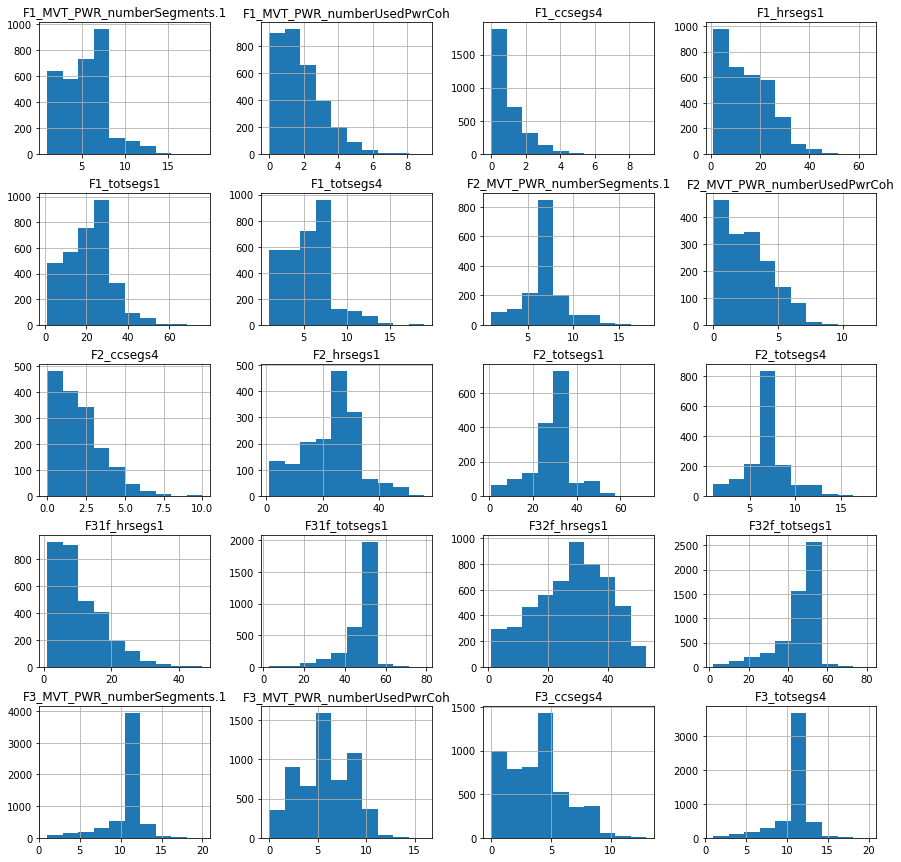

In [54]:
meta.hist(figsize=(15,15));

# BISH Data

Udi specifically used the BISH data file to define his new target variable, `time_left`.  Basically,
he noticed that F3 data was best populated (~75% of the population), so it seems he wanted to 
define a target that may lead to success...  To use this data, he kept only those patients
who had BISH records w/ GA > 34 weeks, which basically means he was no longer attempting to
predict pre-term births so much...  

The BISH file is a disaster though, and one of the ways this disaster manifests is GAs
that go well beyond 40 weeks.  Udi noticed this too, evidenced by throwing out any
`time_left` instances that were negative (in other words, the BISH file's GA for the
F3 measurment was somehow greater than the GA at birth quoted in another data table).

The disaster that is the BISH file goes beyond this though.  For example, in the file, there
include "filename" variables, which a strings incorporating the site (BISH), the patient ID,
the cycle ID, and so on.  Cycle IDs 10, 15, and 20 are basically supposed to correspond with
F1, F2, and F3, respectively.  However, 
* the GA generally extends outside the definitions (F1: 20-24wks, F2: 28-32wks, F3: 34+wks)
    - this could make sense in that the tests can be scheduled at 25 wks or 29 wks, in 
      which case you might think they just get labeled with the cycle ID that makes most sense; however,
      things get messier
* in the BISH file, cycle ID and Fx definitions do not strictly coincide
    - you will notice CID 10, 15, and 20 have GAs ranging over 18-38 wks

In the `CID-Fx Discrepancy` section below, you will find that 
* CID 10 has values less than 20 weeks and more than 30 weeks
* CID 20 has at least 60 values that are less than 34 weeks (than values going up to ~48 weeks)
* CID 15 is the worst:  most of its values (~75%) are less than 24 weeks (28 weeks is the supposed 
  starting point of F2)
  
<b id="redcell">This makes CID a useless way of ordering by time.</b>

If we were to use the BISH file, we would want to instead make a new system that
ordered test times into chunks... Kind of like Fx nomenclature does, but a little
more lenient (e.g., G1: 16-24wks, G2:25-33wks, G3:34+wks).  

**HOWEVER, my 2 cents**:  since both TOI and MON data seem to have associated Fx labels
of some sort (either in the variable name or in an associated column), let's just stick
to the Fx nomenclature and trust that these files were put together ok...  BUT
ONLY FOR THE TIME BEING.  If this project is to continue, we need to get a better understanding
of these discrepancies and inconsistencies...  It's possible Udi/Carlos did not understand the
CID and Fx nomenclature correctly............................

### More on Misunderstanding BISH
Do we have any documentation about the BISH file anyway?  It's not clear to me what the 
file even has in it...

**Some patients have only 1 records**, which is understandable: my interpretation is that they did sensor tests on one occasion, either during F1, F2, or F3. 

**Other patients have 2 or 3 records**, which again is pretty understandable: they have sensor measurements during multiple Fx periods. 

**But some patients have 4-5 records** in the BISH file -- **WHY?** Were they really tested on this many occasions?

These questions led me to realize that I do not understand the BISH file. For example, maybe 5 records means that a patient recorded MON data on 2 occasions and TOI data on 3 other occasions. Maybe one record means they got both MON and TOI testing on the same occasion. But maybe not. There does not seem to be any indication in the BISH file. To really understand more about the patients, we would have to do a lot of exploratory querying that we don't exactly have time for...

### BISH Twins (Remove 'em!)

In [217]:
# Show Twin IDs to compare w/ duplicated TOI PATIDs
#   TOI Dup1: S002-BISH-04030 - not listed as a twin in BISH
#   TOI Dup2: S002-BISH-04033 - not listed as a twin in BISH
bish = pd.read_csv('../data/raw/BISH FETAL GA ASSESSMENT_DB.csv')
bish.columns = map(lambda x: '_'.join(x.lower().split(' ')).replace('.','_'), bish.columns)
bish.set_index('patid', inplace=True)
twins = bish.query('number_of_fetuses > 1').index.unique()
twins

Index(['S002-BISH-04355', 'S002-BISH-04582', 'S002-BISH-05089'], dtype='object', name='patid')

In [252]:
# Ingestion code (thus far)
bish = pd.read_csv('../data/raw/BISH FETAL GA ASSESSMENT_DB.csv')
bish.columns = map(lambda x: '_'.join(x.lower().split(' ')).replace('.','_'), bish.columns)
bish.set_index('patid', inplace=True)
bish = bish.query('number_of_fetuses == 1').drop('number_of_fetuses', axis=1)
bish['cid'] = bish[['final_file_name']].applymap(lambda x: float(x.split('-')[-1].split('.')[0]) if type(x)==str else x)
bish['cid1'] = bish[['final_file_name_1']].applymap(lambda x: float(x.split('-')[-1]) if type(x)==str else x)

### Some BISH Basics (Cols, Shape, Head, etc)

In [253]:
bish.columns

Index(['box_number', 'original_file_name', 'final_file_name',
       'final_file_name_1', 'ga_in_days', 'cid', 'cid1'],
      dtype='object')

In [254]:
bish.shape

(12379, 7)

In [256]:
bish.head()

,box_number,original_file_name,final_file_name,final_file_name_1,ga_in_days,cid,cid1
patid,,,,,,,
S002-BISH-00001,2007-04,S002-BISH-00001-2007-04.physio,S002-BISH-00001-T010-10.physio,S002-BISH-00001-T010-10,150,10.0,10.0
S002-BISH-00001,2007-04,11-22-s002-bish-00001-2007-04.physio,S002-BISH-00001-T010-15.physio,S002-BISH-00001-T010-15,202,15.0,15.0
S002-BISH-00002,2007-04,S002-BISH-00002-2007-04.physio,S002-BISH-00002-T010-10.physio,S002-BISH-00002-T010-10,167,10.0,10.0
S002-BISH-00002,2007-05,10-24-s002-bish-00002-2007-05.physio,S002-BISH-00002-T010-20.physio,S002-BISH-00002-T010-20,242,20.0,20.0
S002-BISH-00003,2007-04,11-01-s002-bish-00003-2007-04.physio,S002-BISH-00003-T010-20.physio,S002-BISH-00003-T010-20,246,20.0,20.0


In [349]:
print(bish.query('cid != cid1').__len__())
bish.query('cid != cid1').head()

95


,box_number,original_file_name,final_file_name,final_file_name_1,ga_in_days,cid,cid1
patid,,,,,,,
S002-BISH-00072,NaN,NaN,NaN,NaN,155,NaN,NaN
S002-BISH-00207,NaN,NaN,NaN,NaN,202,NaN,NaN
S002-BISH-00230,NaN,NaN,NaN,NaN,246,NaN,NaN
S002-BISH-00303,NaN,NaN,NaN,NaN,162,NaN,NaN
S002-BISH-00315,NaN,NaN,NaN,NaN,159,NaN,NaN


In [350]:
bish.reset_index().groupby('patid')['patid'].count().to_frame('cnt').query('cnt > 2').head()

,cnt
patid,
S002-BISH-00009,3
S002-BISH-00015,3
S002-BISH-00017,3
S002-BISH-00022,3
S002-BISH-00026,3


<font color=red size=10 style="font-weight:bold"> The CID-Fx Discrepancy!</font>

,ga_in_days
min,16.571429
25%,22.000000
50%,22.571429
75%,23.142857
max,32.428571


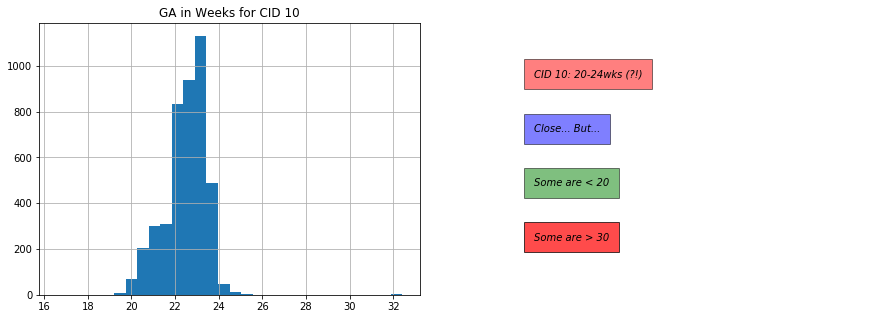

In [396]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
bish.query('cid == 10').ga_in_days.map(lambda x: x/7).hist(bins=30);
plt.title('GA in Weeks for CID 10');
ax = plt.subplot(1,2,2)
ax.axis('off')
ax.text(0.1, 0.8, 'CID 10: 20-24wks (?!)', style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10});
ax.text(0.1, 0.6, 'Close... But...', style='italic',
        bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 10});
ax.text(0.1, 0.4, 'Some are < 20', style='italic',
        bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10});
ax.text(0.1, 0.2, 'Some are > 30', style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.7, 'pad': 10});

bish.query('cid == 10').ga_in_days.map(lambda x: x/7).to_frame().describe()[3:]


,ga_in_days
min,24.571429
25%,28.285714
50%,28.857143
75%,29.714286
max,40.571429


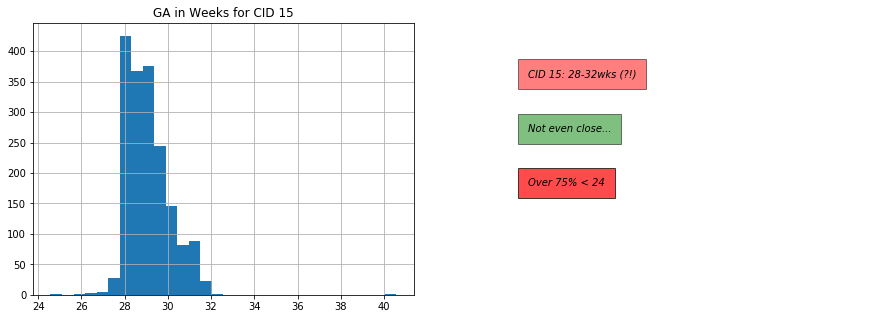

In [395]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
bish.query('cid == 15').ga_in_days.map(lambda x: x/7).hist(bins=30);
plt.title('GA in Weeks for CID 15');
ax = plt.subplot(1,2,2)
ax.axis('off')
ax.text(0.1, 0.8, 'CID 15: 28-32wks (?!)', style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10});
ax.text(0.1, 0.6, 'Not even close...', style='italic',
        bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10});
ax.text(0.1, 0.4, 'Over 75% < 24', style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.7, 'pad': 10});

bish.query('cid == 15').ga_in_days.map(lambda x: x/7).to_frame().describe()[3:]

First 60 rounded values: [21. 28. 30. 31. 32. 33.]


,ga_in_days
min,20.714286
25%,34.142857
50%,34.571429
75%,35.285714
max,48.428571


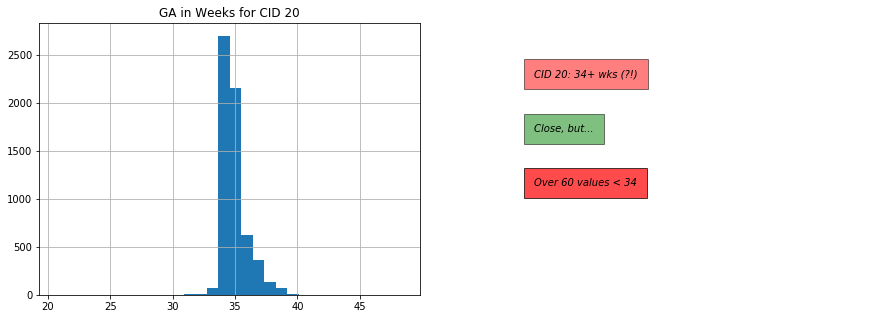

In [415]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
bish.query('cid == 20').ga_in_days.map(lambda x: x/7).hist(bins=30);
plt.title('GA in Weeks for CID 20');
ax = plt.subplot(1,2,2)
ax.axis('off')
ax.text(0.1, 0.8, 'CID 20: 34+ wks (?!)', style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10});
ax.text(0.1, 0.6, 'Close, but...', style='italic',
        bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10});
ax.text(0.1, 0.4, 'Over 60 values < 34', style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.7, 'pad': 10});

bq = bish.query('cid == 20').ga_in_days.map(lambda x: x/7).to_frame()
print('First 60 rounded values:',np.unique(bq.sort_values('ga_in_days').ga_in_days.values[:60].round()))
bq.describe()[3:]

Ok, so basically, what we want to do is choose a cutoff...

For 32wk preterm, we want the cutoff around 220.  For 28wk, around 190.  

Given cutoff, look in Bish file for any patients that have measurements greater
than the cut off...  These patients should have CENSORED F3 data...



In [143]:
bish.query('cid==20').ga_in_days.describe()[3:]/7

min    20.714286
25%    34.142857
50%    34.571429
75%    35.285714
max    48.428571
Name: ga_in_days, dtype: float64

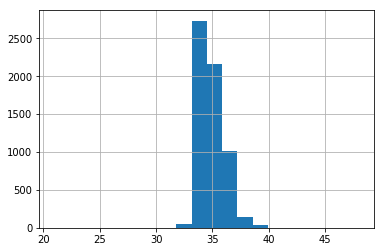

In [149]:
bish.query('cid==20').ga_in_days.map(lambda x: round(x/7)).hist(bins=20)

## Does BISH file contain any info about MON vs TOI sessions?

In [435]:
bish.head(2)

,box_number,original_file_name,final_file_name,final_file_name_1,ga_in_days,cid,cid1
patid,,,,,,,
S002-BISH-00001,2007-04,S002-BISH-00001-2007-04.physio,S002-BISH-00001-T010-10.physio,S002-BISH-00001-T010-10,150,10.0,10.0
S002-BISH-00001,2007-04,11-22-s002-bish-00001-2007-04.physio,S002-BISH-00001-T010-15.physio,S002-BISH-00001-T010-15,202,15.0,15.0


In [438]:
print('Number of time MON is referenced in original file name:',
      len([item for item in bish.original_file_name.dropna() if 'mon' in item.lower()]))

Number of time MON is referenced in original file name: 0


In [439]:
print('Number of time TOI is referenced in original file name:',
      len([item for item in bish.original_file_name.dropna() if 'toi' in item.lower()]))

Number of time TOI is referenced in original file name: 0


In [442]:
print('Number of time MON is referenced in final file name:',
      len([item for item in bish.final_file_name.dropna() if 'mon' in item.lower()]))

Number of time MON is referenced in final file name: 0


In [441]:
print('Number of time TOI is referenced in final file name:',
      len([item for item in bish.final_file_name.dropna() if 'toi' in item.lower()]))

Number of time TOI is referenced in final file name: 0


In [443]:
print('Number of time MON is referenced in final file name (1):',
      len([item for item in bish.final_file_name_1.dropna() if 'mon' in item.lower()]))

Number of time MON is referenced in final file name (1): 0


In [444]:
print('Number of time TOI is referenced in final file name (1):',
      len([item for item in bish.final_file_name_1.dropna() if 'toi' in item.lower()]))

Number of time TOI is referenced in final file name (1): 0


<font class=mon size=10> <b>MON Data</b></font>

In [3]:
rmssd = pd.read_csv('../data/raw/BISH_RMSSD_MONICA_052218_EARLY_SIGNAL2.csv')
mhr = pd.read_csv('../data/raw/Maternal HR XFER 052318.csv')
mvmt = pd.read_csv('../data/raw/maternal_MVMT_monica_EHG_EHG_XFER_240s_Epochs_051818.csv')

In [268]:
rmssd.head()

,PATID,FileName,Age,Site,F11F_ NumberofGoodRWaves,F11F_ NumberofGoodRWaves_SCandRM,F11F_ Mean,F11F_ StDev,F11F_ RMSSD,F11F_ TotNumberofRwaves,...,F32F_ SC_D,F32F_ PERC,F32F_Epochs,F3_Total,F3_AS Total,F3_QS Total,F3_AS Reject,F3_QS Reject,F3_ASR%,F3_QSR%
0,S002-BISH-00509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.806104,97.821086,118.0,127.0,119.0,0.0,19.0,0.0,16.0,0.0
1,S002-BISH-00572,00572-10,F1,BISH,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,S002-BISH-00587,00587-10,F1,BISH,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,S002-BISH-00594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.155322,73.510938,4.0,100.0,79.0,0.0,35.0,0.0,44.3,0.0
4,S002-BISH-00613,00613-10,F1,BISH,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [269]:
mhr.head()

,PATID,Timepoint,File Name,numberSegments,meanPercentBad,startSecond,endSecond,MHR_mean,MHR_median,MHR_stddev,...,MHR_BandPwr2,MHR_BandPwr3,MHR_BandPwr4,maxCrossCorr,lagOfMaxCrossCorr,medianMaxCrossCorr,medianLagOfMaxCrossCorr,numberSegments.1,numberUsedPwrCoh,numberUsedCrsCor
0,S002-BISH-01546,F3,01546-20_exp_250ms.mhr,6,0.0,3078,3445,91.02,91.00,2.79,...,1.809740,0.485221,0.024952,0.187834,-3.90,0.499977,-9.175,6.0,6.0,6.0
1,S002-BISH-04101,F2,04101-15_exp_250ms.mhr,30,0.0,2409,4211,86.91,87.00,3.01,...,1.131280,1.019080,0.022936,0.110428,4.35,0.590114,3.675,30.0,30.0,30.0
2,S002-BISH-07004,F1,07004-10_exp_250ms.mhr,30,0.0,2008,11979,78.88,79.00,4.03,...,1.797840,1.718050,0.029149,0.029641,-16.65,0.566702,-0.875,30.0,30.0,30.0
3,S002-BISH-06159,F3,06159-20_exp_250ms.mhr,50,0.0,1878,4899,88.58,88.17,5.46,...,3.801840,2.685170,0.031287,0.081311,10.85,0.651371,2.575,50.0,50.0,50.0
4,S002-BISH-05521,F3,05521-20_exp_250ms.mhr,23,0.0,1725,3125,79.00,78.00,3.48,...,0.820086,0.418666,0.019242,0.288607,0.25,0.673103,1.325,23.0,23.0,22.0


In [270]:
mvmt.head()

,Study ID,File Name,StudyID,numberSegments,meanPercentBad,startSecond,endSecond,HR_mean,HR_median,HR_stddev,...,HR_BandPwr2,HR_BandPwr3,HR_BandPwr4,maxCrossCorr,lagOfMaxCrossCorr,medianMaxCrossCorr,medianLagOfMaxCrossCorr,numberSegments__1,numberUsedPwrCoh,numberUsedCrsCor
0,S002-BISH-00509-T010-20,00509-20_exp_250ms.ehg,00509-20_exp_250ms.ehg,12,0.00,381.0,3381.0,55.17,46.00,26.82,...,337.406,0.529147,0.026194,0.804556,0.85,0.804556,0.85,12.0,12.0,1.0
1,S002-BISH-00674-T010-20,00674-20_exp_250ms.ehg,00674-20_exp_250ms.ehg,9,0.00,42.6,3042.6,52.57,45.00,22.44,...,307.086,1.217650,0.029924,0.868726,-0.05,0.868726,-0.05,9.0,9.0,1.0
2,S002-BISH-00686-T010-20,00686-20_exp_250ms.ehg,00686-20_exp_250ms.ehg,11,0.00,423.3,3461.3,55.35,44.00,30.64,...,549.000,0.622030,0.031356,0.957542,-1.65,0.957542,-1.65,11.0,11.0,1.0
3,S002-BISH-00697-T010-20,00697-20_exp_250ms.ehg,00697-20_exp_250ms.ehg,10,0.01,208.3,3455.3,68.37,52.17,40.43,...,857.884,1.333710,0.039657,NaN,NaN,NaN,NaN,10.0,10.0,0.0
4,S002-BISH-00698-T010-20,00698-20_exp_250ms.ehg,00698-20_exp_250ms.ehg,12,0.00,183.3,3195.3,52.15,44.00,23.98,...,259.629,0.188972,0.025283,0.852156,0.30,0.852156,0.30,12.0,12.0,1.0


# Timing Considerations
Each `MON` variable has a way to place it in time (given we trust both the CID and Fx
time orderings passed onto us from Udi).  
* RMSSD: the `FileName` variable has what looks like a CID (though it's `10` for every record)
* MHR: (i) has an Fx column (`Timepoint`);  (ii) has a `File Name` variable that looks to have CID info
* MVMT: has a `Study ID` variable that houses CID info

In [417]:
rmssd.FileName.apply(lambda x: x.split('-')[-1] if type(x)==str else x).unique()

array([nan, '10'], dtype=object)

In [421]:
mhr.Timepoint.unique()

array(['F3', 'F2', 'F1'], dtype=object)

In [419]:
mvmt['Study ID'].apply(lambda x: x.split('-')[-1] if type(x)==str else x).unique()

array(['20', '10', '15'], dtype=object)

### Further exploration of RMSSD-Fx vs RMSSD-CID 
Note that there is a `FileName` variable that appears to possibly house CID info, but
there is also an `Age` var that directly houses Fx info.  Let's compare!

**Conclusions**: 
* F1 always pairs with CID 10 in this file
* Only F1/CID10 is represented in this file

In [5]:
rmssd.Age.unique()

array([nan, 'F1'], dtype=object)

In [8]:
cid = rmssd.FileName.apply(lambda x: x.split('-')[-1] if type(x)==str else x)
(cid + rmssd.Age).unique()

array([nan, '10F1'], dtype=object)

### Further exploration of MHR-Fx vs MHR-CID
Nice... The CIDs and Fx's align as they should:
* F1 - CID10
* F2 - CID15
* F3 - CID20

In [431]:
mhr['CID'] = mhr['File Name'].map(lambda x: x.split('-')[1].split('_')[0] if type(x)==str else x)
mhr.rename(columns={'Timepoint':'Fx'}, inplace=True)
mhr['CIDFx'] = mhr.Fx+mhr.CID

In [434]:
mhr.CIDFx.unique()

array(['F320', 'F215', 'F110'], dtype=object)

### Conclusion: Since all 3 MON tables have CID, let's use that
We found all 3 tables to use CID in one way or another.  The MHR table also has
Fx nomenclature, and we found it strictly obeys the relationship we expected it 
to: F1/CID10, F2/CID15, F3/CID20.

In [58]:
# Load raw tables
rmssd = pd.read_csv('../data/raw/BISH_RMSSD_MONICA_052218_EARLY_SIGNAL2.csv')
mhr = pd.read_csv('../data/raw/Maternal HR XFER 052318.csv')
mvmt = pd.read_csv('../data/raw/maternal_MVMT_monica_EHG_EHG_XFER_240s_Epochs_051818.csv')

# Append CID columns
rmssd['cid'] = rmssd.FileName.apply(lambda x: x.split('-')[-1] if type(x)==str else x)
mhr['cid'] = mhr['File Name'].map(lambda x: x.split('-')[1].split('_')[0] if type(x)==str else x)
mvmt['cid'] = mvmt['Study ID'].apply(lambda x: x.split('-')[-1] if type(x)==str else x)

# Append PATID columns, if necessary 
mvmt['patid'] = mvmt['Study ID'].apply(lambda x: '-'.join(x.split('-')[:-2]))

# Lowercase Column Names
rmssd.columns = map(str.lower, rmssd.columns)
mhr.columns = map(str.lower, mhr.columns)
mvmt.columns = mvmt.columns.to_frame().replace(' ','',regex=True).iloc[:,0].map(str.lower).values

# Set patid as index
rmssd.set_index('patid', inplace=True)
mhr.set_index('patid', inplace=True)
mvmt.set_index('patid', inplace=True)

<font class=mon size=10><b> MON: RMSSD</b></font>

## Not all is Right w/ RMSSD!
**UPDATE (Dec 9)**
<font class=update>

Yikes~

The RMSSD file is actually pretty weird... There is the `Age` var, which is always `F1` or `NaN`,
yet look at the var names -- there are F1, F2, and F3 var names, similar to the TOI data.
</font>

In [61]:
print('Example of vars ranging across the F1-F3 time periods:')
mean_vars = [item for item in rmssd.columns if 'mean' in item]
mean_vars

Example of vars ranging across the F1-F3 time periods:


['f11f_ mean ',
 'f12f_ mean ',
 'f21f_ mean ',
 'f22f_ mean ',
 'f31f_ mean ',
 'f32f_ mean ']

My hypothesis would be that, **maybe**, whenever the `Age` variable is `F1`, we have a
record with only F1 data...but that when it says `Nan` we can have either F2 or F3 data.

In [64]:
rmssd.query('age=="F1"').head()

,filename,age,site,f11f_ numberofgoodrwaves,f11f_ numberofgoodrwaves_scandrm,f11f_ mean,f11f_ stdev,f11f_ rmssd,f11f_ totnumberofrwaves,f11f_ iqr,...,f32f_ perc,f32f_epochs,f3_total,f3_as total,f3_qs total,f3_as reject,f3_qs reject,f3_asr%,f3_qsr%,cid
patid,,,,,,,,,,,,,,,,,,,,,
S002-BISH-00572,00572-10,F1,BISH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
S002-BISH-00587,00587-10,F1,BISH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
S002-BISH-00613,00613-10,F1,BISH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
S002-BISH-00640,00640-10,F1,BISH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
S002-BISH-00643,00643-10,F1,BISH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,90.613775,73.0,320.0,106.0,0.0,43.0,0.0,40.6,0.0,10


Wow.... I am definitely WRONG!

I would say that 
* the `FileName` and `Age` vars are somehow wrong and useless
* we should "trust" (for lack of a better word!) that the var names indicate the true timings

My next suspicion might be that a patient only has 1 recording, in either F1, F2, or F3,
and that the `Age` and `FileName` vars are just incorrect.

In [65]:
rmssd[mean_vars].head(10)

,f11f_ mean,f12f_ mean,f21f_ mean,f22f_ mean,f31f_ mean,f32f_ mean
patid,,,,,,
S002-BISH-00509,NaN,NaN,NaN,NaN,NaN,411.856240
S002-BISH-00572,NaN,378.396025,NaN,NaN,NaN,NaN
S002-BISH-00587,NaN,404.163497,NaN,NaN,NaN,NaN
S002-BISH-00594,NaN,NaN,NaN,NaN,NaN,409.239411
S002-BISH-00613,NaN,416.219354,NaN,NaN,NaN,NaN
S002-BISH-00623,NaN,NaN,NaN,NaN,497.08769,480.756401
S002-BISH-00640,NaN,NaN,NaN,NaN,NaN,NaN
S002-BISH-00643,NaN,423.127195,NaN,NaN,NaN,446.857026
S002-BISH-00655,NaN,419.486361,NaN,NaN,NaN,NaN


WRONG again, mofo!  

Look @ record \#7:
* F12F_Mean: 423.1
* F32F_Mean: 446.9

**CONCLUSION**:  Just ignore the `FileName` and `Age` vars, as they seem to be wrong/misleading.

## RMSSD Basics
<b>Dec 9, 2019</b>

In [66]:
rmssd.shape

(5222, 101)

In [68]:
f11f = [item for item in rmssd.columns if 'f11f' in item]
f12f = [item for item in rmssd.columns if 'f12f' in item]
f21f = [item for item in rmssd.columns if 'f21f' in item]
f22f = [item for item in rmssd.columns if 'f22f' in item]
f31f = [item for item in rmssd.columns if 'f31f' in item]
f32f = [item for item in rmssd.columns if 'f32f' in item]
[print(item) for item in f11f];

print('\nDo all FxyF lists have same number of items?\n')
print('\t',len(f11f) == len(f12f) == len(f21f) == len(f22f) == len(f31f) == len(f32f))
print('\nLength:', len(f11f))

f11f_ numberofgoodrwaves 
f11f_ numberofgoodrwaves_scandrm 
f11f_ mean 
f11f_ stdev 
f11f_ rmssd 
f11f_ totnumberofrwaves 
f11f_ iqr 
f11f_ sc_a 
f11f_ sc_d 
f11f_ perc 
f11f_epochs

Do all FxyF lists have same number of items?

	 True

Length: 11


In [66]:
print('Do all FxyF lists have the same vars (e.g., Mean, StDev, IQR, etc)?')
clean_up_fcn = lambda x: x.split('_')[1].replace(' ','')
list(map(clean_up_fcn, f11f)) == \
    list(map(clean_up_fcn, f12f)) == \
    list(map(clean_up_fcn, f21f)) == \
    list(map(clean_up_fcn, f22f)) == \
    list(map(clean_up_fcn, f31f)) == \
    list(map(clean_up_fcn, f32f))

Do all FxyF lists have the same vars (e.g., Mean, StDev, IQR, etc)?


True

<font size=4>
<b>Discrepancy</b>: There are 6 FxyF combos and 11 vars per combo, resulting in 66 vars.  But the data shape
suggests there are 101 vars.
</font>

In [71]:
[var for var in rmssd.columns 
     if 'F1' not in var 
     and 'F2' not in var
     and 'F3' not in var]

['PATID', 'FileName', 'Age', 'Site']

In [78]:
other_vars = [var for var in rmssd.columns 
     if '1f' not in var 
     and '2f' not in var]
print('Num of other vars:', len(other_vars))
print('Num(Other) + Num(FxyF):', len(other_vars) + 66)
other_vars

Num of other vars: 35
Num(Other) + Num(FxyF): 101


['filename',
 'age',
 'site',
 'f1_total',
 'f1_as total',
 'f1_qs total',
 'f1_as reject',
 'f1_qs reject',
 'f1_asr%',
 'f1_qsr%',
 'f2_study id +',
 'f2_study id',
 'f2_study id.1',
 'f2_study id.2',
 'f2_site',
 'f2_total',
 'f2_as total',
 'f2_qs total',
 'f2_as reject',
 'f2_qs reject',
 'f2_asr%',
 'f2_qsr%',
 'f3_study id +',
 'f3_study id',
 'f3_study id.1',
 'f3_study id.2',
 'f3_site',
 'f3_total',
 'f3_as total',
 'f3_qs total',
 'f3_as reject',
 'f3_qs reject',
 'f3_asr%',
 'f3_qsr%',
 'cid']

Ok, so these are mostly meta data vars.  

## RMSSD Nullity
<b>Dec 9, 2019</b>

Assuming we drop all `other_vars` columns, what variables have at least 50% of their data?

Turns out only F1 and F3 vars have any data worth talking about (spefically, their 2F vars), and 
for our predictive models, we cannot really use F3 data.  

In fact, you can make this nullity number up to
*  86% before any F2 vars come into play (i.e., F2 vars represent 14% of the population or less)
*  96% before any F11F vars crop up (i.e., F11F vars represent 3-4% of the population, tops)

In [79]:
f1_vars = [var for var in rmssd.columns 
           if 'f1' in var.lower()
           and ('1f' in var.lower() or '2f' in var.lower())]
f2_vars = [var for var in rmssd.columns
           if 'f2' in var.lower()
           and ('1f' in var.lower() or '2f' in var.lower())]
f3_vars = [var for var in rmssd.columns
           if 'f3' in var.lower()
           and ('1f' in var.lower() or '2f' in var.lower())]

In [99]:
rmssd.drop(other_vars, axis=1).isnull().\
    apply(lambda x: round(100 * x.sum()/len(rmssd),1)).to_frame('nullity').\
    query('nullity <= 50')

,nullity
f12f_ numberofgoodrwaves,32.7
f12f_ numberofgoodrwaves_scandrm,32.7
f12f_ mean,32.7
f12f_ stdev,32.7
f12f_ rmssd,33.0
f12f_ totnumberofrwaves,32.7
f12f_ iqr,32.7
f12f_ sc_a,32.7
f12f_ sc_d,32.7
f12f_ perc,32.7


In [130]:
# This shows that we can keep all of the F12F vars
#  -- note how limited the F11F vars are (worse nullity than 95%)
rmssd.drop(other_vars + f2_vars + f3_vars, axis=1).isnull().\
    apply(lambda x: round(100 * x.sum()/len(rmssd),1)).to_frame('nullity').\
    query('nullity <= 95')

,nullity
F12F_ NumberofGoodRWaves,32.7
F12F_ NumberofGoodRWaves_SCandRM,32.7
F12F_ Mean,32.7
F12F_ StDev,32.7
F12F_ RMSSD,33.0
F12F_ TotNumberofRwaves,32.7
F12F_ IQR,32.7
F12F_ SC_A,32.7
F12F_ SC_D,32.7
F12F_ PERC,32.7


In [141]:
# This shows that we can keep all of the F32F vars
#  -- note how limited the F31F vars are (worse nullity than 83%)
#  -- not that the nullity matters much since we are not using F3 vars in predictive model
rmssd.drop(other_vars + f1_vars + f2_vars, axis=1).isnull().\
    apply(lambda x: round(100 * x.sum()/len(rmssd),1)).to_frame('nullity').\
    query('nullity <= 83')

,nullity
F32F_ NumberofGoodRWaves,16.3
F32F_ NumberofGoodRWaves_SCandRM,16.3
F32F_ Mean,16.3
F32F_ StDev,16.3
F32F_ RMSSD,17.0
F32F_ TotNumberofRwaves,16.3
F32F_ IQR,16.3
F32F_ SC_A,16.3
F32F_ SC_D,16.3
F32F_ PERC,16.3


In [131]:
f12f_vars = [var for var in rmssd.columns 
           if 'f1' in var.lower()
           and '2f' in var.lower()]

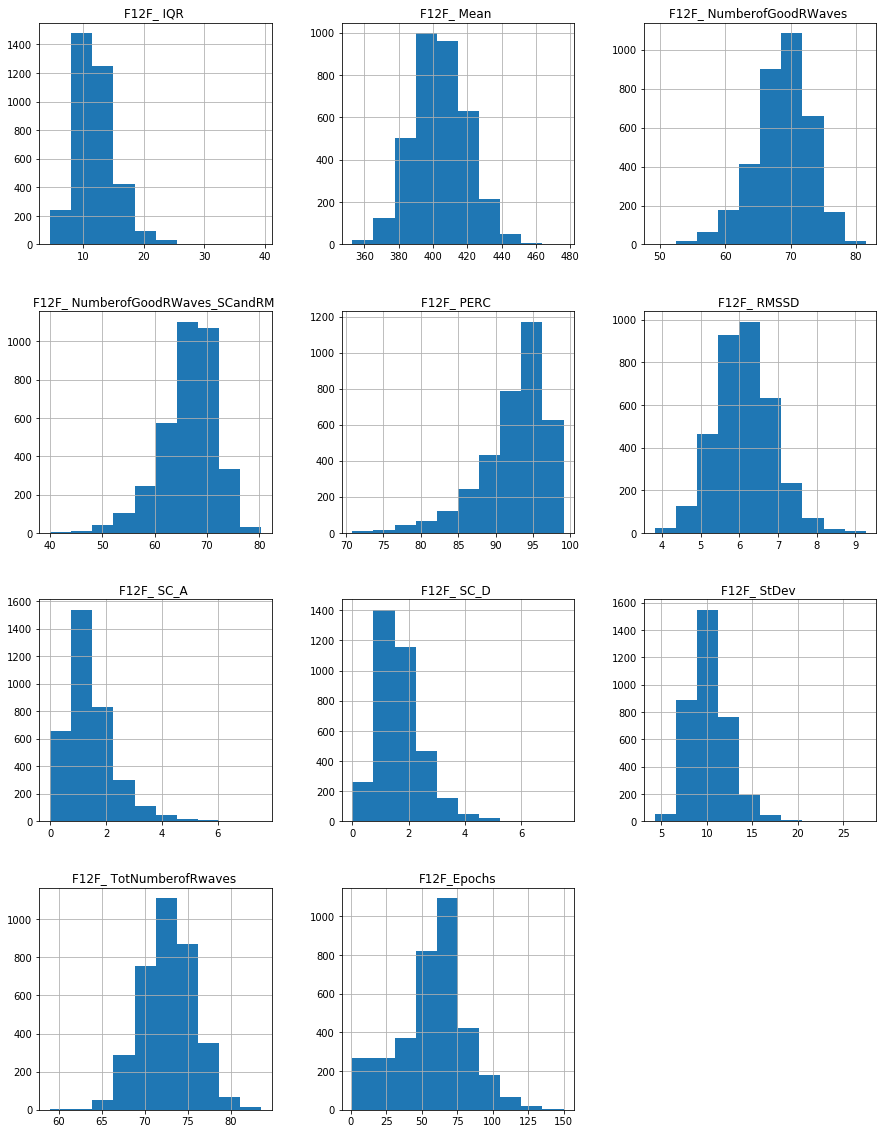

In [133]:
rmssd[f12f_vars].hist(figsize=(15,20));

We know that David said to only use band power vars for TOI.  Might this be true of MON as well?
There is also the fact that some of the TOI and MON vars are more like meta-data than data, e.g.,
the `number of segments` variables usually record how many segments were used to arrive at some statistic.  This
might proxy as a "data quality" variable...but it's not clear it is really useful.

### RMSSD CODE THUS FAR
<b>Dec 9, 2019</b>

In [142]:
rmssd = pd.read_csv('../data/raw/BISH_RMSSD_MONICA_052218_EARLY_SIGNAL2.csv')
rmssd.columns = map(lambda x: x.lower().replace(' ',''), rmssd.columns)
f12f_vars = [var for var in rmssd.columns 
           if 'f1' in var and '2f' in var]
rmssd.set_index('patid', inplace=True)
rmssd = rmssd[f12f_vars]

# Patient Uniqueness
<b>Dec 6, 2019</b>

Here, we find that RMSSD is the only table that has one record per patient, providing
evidence that we're right about it only having CID10 measurements.

Both MHR and MVMT can have multiple records per patient ID, which means that
we would want to flatten the table more ("widen it") before we join all the MON tables. However,
note that the difference between the `number of records` and `unique patients` is relatively
small in both tables:  of `3,968 records` in MHR there are `3,589 patients`, which is 
a difference of `379`.  Similarly, for MVMT, the difference is quite small: `194`.

<br>
<font class=update>
    <b>UPDATE (Dec 9)</b>:  Ulimately, what I found was that RMSSD was already pre-widened into
    Fx columns -- and that the CID/Fx info in the `FileName` and `Age` vars is somehow wrong/misleading.  Both
    MHR and MVMT tables are not pre-widened, which is why a PATID can appear in multiple records.  
</font>

In [496]:
print('RMSSD Records:', rmssd.shape[0])
print('RMSSD Unique PIDs:', rmssd.index.unique().__len__())
print('Difference:', rmssd.shape[0] - rmssd.index.unique().__len__())

RMSSD Records: 5222
RMSSD Unique PIDs: 5222
Difference: 0


In [497]:
print('MHR Records:', mhr.shape[0])
print('MHR Unique PIDs:', mhr.index.unique().__len__())
print('Difference:', mhr.shape[0] - mhr.index.unique().__len__())

MHR Records: 3968
MHR Unique PIDs: 3589
Difference: 379


In [498]:
print('MVMT Records:', mvmt.shape[0])
print('MVMT Unique PIDs:', mvmt.index.unique().__len__())
print('Difference:', mvmt.shape[0] - mvmt.index.unique().__len__())

MVMT Records: 3076
MVMT Unique PIDs: 2882
Difference: 194


<font class=mon size=10><b> MON MHR</b></font>

## MHR Basics

In [192]:
# Reload, in case
mhr = pd.read_csv('../data/raw/Maternal HR XFER 052318.csv')
mhr['cid'] = mhr['File Name'].map(lambda x: x.split('-')[1].split('_')[0] if type(x)==str else x)
mhr.columns = map(str.lower, mhr.columns)
mhr.set_index('patid', inplace=True)

In [193]:
mhr.shape

(3968, 25)

In [178]:
mhr.columns

Index(['timepoint', 'file name', 'numbersegments', 'meanpercentbad',
       'startsecond', 'endsecond', 'mhr_mean', 'mhr_median', 'mhr_stddev',
       'mhr_25th', 'mhr_75th', 'mhr_min', 'mhr_max', 'mhr_bandpwr1',
       'mhr_bandpwr2', 'mhr_bandpwr3', 'mhr_bandpwr4', 'maxcrosscorr',
       'lagofmaxcrosscorr', 'medianmaxcrosscorr', 'medianlagofmaxcrosscorr',
       'numbersegments.1', 'numberusedpwrcoh', 'numberusedcrscor', 'cid'],
      dtype='object')

In [179]:
mhr.head(3)

,timepoint,file name,numbersegments,meanpercentbad,startsecond,endsecond,mhr_mean,mhr_median,mhr_stddev,mhr_25th,...,mhr_bandpwr3,mhr_bandpwr4,maxcrosscorr,lagofmaxcrosscorr,medianmaxcrosscorr,medianlagofmaxcrosscorr,numbersegments.1,numberusedpwrcoh,numberusedcrscor,cid
patid,,,,,,,,,,,,,,,,,,,,,
S002-BISH-01546,F3,01546-20_exp_250ms.mhr,6,0.0,3078,3445,91.02,91.0,2.79,89.0,...,0.485221,0.024952,0.187834,-3.90,0.499977,-9.175,6.0,6.0,6.0,20
S002-BISH-04101,F2,04101-15_exp_250ms.mhr,30,0.0,2409,4211,86.91,87.0,3.01,85.0,...,1.019080,0.022936,0.110428,4.35,0.590114,3.675,30.0,30.0,30.0,15
S002-BISH-07004,F1,07004-10_exp_250ms.mhr,30,0.0,2008,11979,78.88,79.0,4.03,76.0,...,1.718050,0.029149,0.029641,-16.65,0.566702,-0.875,30.0,30.0,30.0,10


In [181]:
# Generally "good" data
mhr.meanpercentbad.unique()

array([0.  , 0.04, 0.02, 0.01, 0.03, 0.08, 0.14, 0.22, 0.05, 0.28, 0.06])

In [185]:
nsegs = mhr.numbersegments.unique()
nsegs.sort()
nsegs

array([ 0,  3,  5,  6,  7,  9, 11, 13, 15, 16, 17, 19, 20, 22, 23, 24, 25,
       26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
       60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 74, 80])

In [187]:
nsegs1 = mhr['numbersegments.1'].unique()
nsegs1.sort()
nsegs1

array([ 3.,  5.,  6.,  7.,  9., 11., 13., 15., 16., 17., 19., 20., 22.,
       23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.,
       36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48.,
       49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59., 60., 61.,
       62., 63., 64., 65., 66., 67., 68., 70., 71., 74., 80., nan])

In [190]:
npow = mhr.numberusedpwrcoh.unique()
npow.sort()
npow

array([ 3.,  5.,  6.,  7.,  9., 11., 13., 15., 16., 17., 19., 20., 22.,
       23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.,
       36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48.,
       49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59., 60., 61.,
       62., 63., 64., 65., 66., 67., 68., 70., 71., 74., 80., nan])

In [191]:
ncor = mhr.numberusedcrscor.unique()
ncor.sort()
ncor

array([ 3.,  5.,  6.,  7.,  9., 11., 13., 15., 16., 17., 19., 20., 21.,
       22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34.,
       35., 36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47.,
       48., 49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59., 60.,
       61., 62., 63., 64., 65., 66., 69., 72., 78., nan])

## MHR Nullity
**Dec 9, 2019**

MHR generally has good data.

In [186]:
mhr.isnull().sum()

timepoint                  0
file name                  0
numbersegments             0
meanpercentbad             0
startsecond                0
endsecond                  0
mhr_mean                   5
mhr_median                 5
mhr_stddev                 5
mhr_25th                   5
mhr_75th                   5
mhr_min                    5
mhr_max                    5
mhr_bandpwr1               5
mhr_bandpwr2               5
mhr_bandpwr3               5
mhr_bandpwr4               5
maxcrosscorr               5
lagofmaxcrosscorr          5
medianmaxcrosscorr         5
medianlagofmaxcrosscorr    5
numbersegments.1           5
numberusedpwrcoh           5
numberusedcrscor           5
cid                        0
dtype: int64

## MHR Drop Cols

In [188]:
# I would drop the "CID" column too, but ultimately I won't create it in the first
# place (will just use the "timepoint" column for Fx references)
mhr_drop_cols = ['file name', 'numbersegments', 'meanpercentbad',
                'startsecond', 'endsecond', 'numbersegments.1', 
                'numberusedpwrcoh', 'numberusedcrscor']
mhr.drop(mhr_drop_cols, axis=1, inplace=True)

## MHR Band Power
**Dec 9, 2019**

For many types of geophysical phenomena I've studied, the intensity of the
band power over time is an important feature of a signal.  However, with medical instruments,
this feature can be greatly distorted by many things, including:
* proper/improper placement of the instrument leads
* calibration differences among devices used at a site
* calibration differences among devices used at different sites
* whether or not a device was used against skin or clothing, etc

So, while intensity may still have some significance here, we cannot be fully sure it will.  More 
importantly, it is likely that the relative importances between sub-band powers is washed out
due to these kinds of things.  

Point is, we do not necessarily have to drop the absolute band powers, but it is likely
a good move to also include relative powers.  (In fact, for the TOI data, this is exactly
what David recommended Udi do...so he would likely recommend the same here.)

In [198]:
mhr['bandpwr'] = mhr.mhr_bandpwr1 + mhr.mhr_bandpwr2 + mhr.mhr_bandpwr3 + mhr.mhr_bandpwr4
mhr['relative_bandpwr1'] = mhr.mhr_bandpwr1/mhr.bandpwr
mhr['relative_bandpwr2'] = mhr.mhr_bandpwr2/mhr.bandpwr
mhr['relative_bandpwr3'] = mhr.mhr_bandpwr3/mhr.bandpwr
mhr['relative_bandpwr4'] = mhr.mhr_bandpwr1/mhr.bandpwr

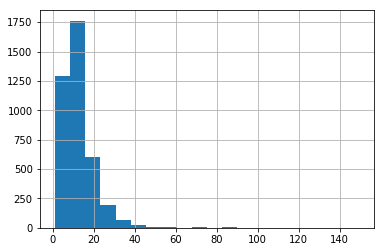

In [204]:
mhr.bandpwr.hist(bins=20);

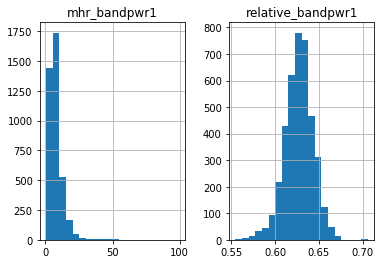

In [201]:
mhr[['mhr_bandpwr1','relative_bandpwr1']].hist(bins=20);

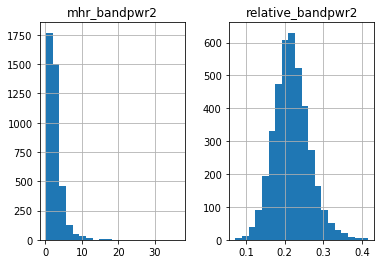

In [202]:
mhr[['mhr_bandpwr2','relative_bandpwr2']].hist(bins=20);

### MHR Code So Far
**Dec 9, 2019**

In [205]:
mhr = pd.read_csv('../data/raw/Maternal HR XFER 052318.csv')
mhr.columns = map(str.lower, mhr.columns)
mhr.set_index('patid', inplace=True)
mhr_drop_cols = ['file name', 'numbersegments', 'meanpercentbad',
                'startsecond', 'endsecond', 'numbersegments.1', 
                'numberusedpwrcoh', 'numberusedcrscor']
mhr.drop(mhr_drop_cols, axis=1, inplace=True)
mhr['bandpwr'] = mhr.mhr_bandpwr1 + mhr.mhr_bandpwr2 + mhr.mhr_bandpwr3 + mhr.mhr_bandpwr4
mhr['relative_bandpwr1'] = mhr.mhr_bandpwr1/mhr.bandpwr
mhr['relative_bandpwr2'] = mhr.mhr_bandpwr2/mhr.bandpwr
mhr['relative_bandpwr3'] = mhr.mhr_bandpwr3/mhr.bandpwr
mhr['relative_bandpwr4'] = mhr.mhr_bandpwr1/mhr.bandpwr

In [207]:
mhr.head(3)

,timepoint,mhr_mean,mhr_median,mhr_stddev,mhr_25th,mhr_75th,mhr_min,mhr_max,mhr_bandpwr1,mhr_bandpwr2,...,mhr_bandpwr4,maxcrosscorr,lagofmaxcrosscorr,medianmaxcrosscorr,medianlagofmaxcrosscorr,bandpwr,relative_bandpwr1,relative_bandpwr2,relative_bandpwr3,relative_bandpwr4
patid,,,,,,,,,,,,,,,,,,,,,
S002-BISH-01546,F3,91.02,91.0,2.79,89.0,93.00,84.9987,98.0013,4.22767,1.80974,...,0.024952,0.187834,-3.90,0.499977,-9.175,6.547583,0.645684,0.276398,0.074107,0.645684
S002-BISH-04101,F2,86.91,87.0,3.01,85.0,89.00,78.9987,99.0013,3.85668,1.13128,...,0.022936,0.110428,4.35,0.590114,3.675,6.029976,0.639585,0.187609,0.169002,0.639585
S002-BISH-07004,F1,78.88,79.0,4.03,76.0,81.62,63.9973,93.0013,6.26111,1.79784,...,0.029149,0.029641,-16.65,0.566702,-0.875,9.806149,0.638488,0.183338,0.175201,0.638488


## The Need for MHR Widening
**Dec 6, 2019**

Here we show that the MHR table is not wide enough: basically, we need to pivot the timepoint
column into the variables to produce Fx-oriented variables.


### Numbers of Patients Per Record Count
**Dec 6, 2019**


In [505]:
mhr.reset_index().groupby('patid')['patid'].count().to_frame('cnt').groupby('cnt')['cnt'].count()

cnt
1    3219
2     361
3       9
Name: cnt, dtype: int64

### MHR: Reason for Multiple Records
**Dec 6, 2019**


What we find here is that any patient ID with multiple records is
due to having multiple testing sessions spanning different CIDs.

1. We find the PATIDs with greater than 1 (gt1) record
2. We compute the min and max CID for each gt1 patient
3. We take the difference, max - min
4. We query whether there exists any difference equal to zero 
    - Answer: No.

<font style="background-color:yellow" size=4>
    <b>SOLUTION</b>: Widen the MON MHR table by defining CID variables, similarly
    to how the TOI table uses Fx variables.
</font>

In [146]:
# Reload, if necessary
mhr = pd.read_csv('../data/raw/Maternal HR XFER 052318.csv')
mhr['cid'] = mhr['File Name'].map(lambda x: x.split('-')[1].split('_')[0] if type(x)==str else x)
mhr.columns = map(str.lower, mhr.columns)
mhr.set_index('patid', inplace=True)


In [147]:
gt1_index = mhr.reset_index().groupby('patid')['patid'].count().to_frame('cnt').query('cnt > 1').index
gt1_min_max = mhr.loc[gt1_index,['cid']].groupby('patid')['cid'].agg([min,max]).astype(float)
gt1_min_max.head()

,min,max
patid,,
S002-BISH-00791,10.0,20.0
S002-BISH-00853,10.0,15.0
S002-BISH-01011,10.0,20.0
S002-BISH-01172,10.0,20.0
S002-BISH-01190,10.0,20.0


In [148]:
gt1_min_max_diff = gt1_min_max.apply(lambda row: row['max']-row['min'], axis=1).to_frame('diff')
gt1_min_max_diff.head()

,diff
patid,
S002-BISH-00791,10.0
S002-BISH-00853,5.0
S002-BISH-01011,10.0
S002-BISH-01172,10.0
S002-BISH-01190,10.0


In [149]:
gt1_min_max_diff.query('diff==0').__len__()

0

## MHR Widening Scheme
**Dec 9, 2019**

In [210]:
shape = mhr.shape
patid = mhr.index.unique().__len__()
print('shape:',shape)
print('unique patid:',patid)

shape: (3968, 21)
unique patid: 3589


In [215]:
mhr1 = mhr.query("timepoint=='F1'").drop('timepoint', axis=1)
mhr1.columns = map(lambda x: 'f1_'+x, mhr1.columns)
mhr2 = mhr.query("timepoint=='F2'").drop('timepoint', axis=1)
mhr2.columns = map(lambda x: 'f2_'+x, mhr2.columns)
mhr3 = mhr.query("timepoint=='F3'").drop('timepoint', axis=1)
mhr3.columns = map(lambda x: 'f3_'+x, mhr3.columns)

In [216]:
mhr1.columns

Index(['f1_mhr_mean', 'f1_mhr_median', 'f1_mhr_stddev', 'f1_mhr_25th',
       'f1_mhr_75th', 'f1_mhr_min', 'f1_mhr_max', 'f1_mhr_bandpwr1',
       'f1_mhr_bandpwr2', 'f1_mhr_bandpwr3', 'f1_mhr_bandpwr4',
       'f1_maxcrosscorr', 'f1_lagofmaxcrosscorr', 'f1_medianmaxcrosscorr',
       'f1_medianlagofmaxcrosscorr', 'f1_bandpwr', 'f1_relative_bandpwr1',
       'f1_relative_bandpwr2', 'f1_relative_bandpwr3', 'f1_relative_bandpwr4'],
      dtype='object')

In [220]:
mhr_wide = mhr1.join(mhr2, how='outer').join(mhr3, how='outer')
mhr_wide.head(3)

,f1_mhr_mean,f1_mhr_median,f1_mhr_stddev,f1_mhr_25th,f1_mhr_75th,f1_mhr_min,f1_mhr_max,f1_mhr_bandpwr1,f1_mhr_bandpwr2,f1_mhr_bandpwr3,...,f3_mhr_bandpwr4,f3_maxcrosscorr,f3_lagofmaxcrosscorr,f3_medianmaxcrosscorr,f3_medianlagofmaxcrosscorr,f3_bandpwr,f3_relative_bandpwr1,f3_relative_bandpwr2,f3_relative_bandpwr3,f3_relative_bandpwr4
patid,,,,,,,,,,,,,,,,,,,,,
S002-BISH-00509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.025345,0.039950,26.05,0.605684,-4.55,6.882483,0.628650,0.247146,0.120521,0.628650
S002-BISH-00686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.030062,0.034699,24.40,0.592523,-0.30,12.901842,0.629245,0.203455,0.164969,0.629245
S002-BISH-00697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.021520,0.092426,20.70,0.568524,4.25,4.418997,0.607699,0.224749,0.162683,0.607699


### The MHR Wide Nullity is NOT GOOD :-(

In [295]:
mhr_nullity = mhr_wide.isnull().sum().map(lambda x: round(100 * x / len(mhr_wide), 1)).to_frame('nullity')
mhr_nullity

,nullity
f1_mhr_mean,96.9
f1_mhr_median,96.9
f1_mhr_stddev,96.9
f1_mhr_25th,96.9
f1_mhr_75th,96.9
f1_mhr_min,96.9
f1_mhr_max,96.9
f1_mhr_bandpwr1,96.9
f1_mhr_bandpwr2,96.9
f1_mhr_bandpwr3,96.9


In [296]:
f1 = [row[1].nullity for row in mhr_nullity.reset_index().iterrows() if 'f1' in row[1]['index']]
[min(f1), max(f1)]

[96.9, 96.9]

In [297]:
f2 = [row[1].nullity for row in mhr_nullity.reset_index().iterrows() if 'f2' in row[1]['index']]
[min(f2), max(f2)]

[86.8, 86.8]

In [298]:
f3 = [row[1].nullity for row in mhr_nullity.reset_index().iterrows() if 'f3' in row[1]['index']]
[min(f3), max(f3)]

[5.9, 5.9]

## MHR: Final Code

In [ ]:
mhr = pd.read_csv('../data/raw/Maternal HR XFER 052318.csv')
mhr.columns = map(str.lower, mhr.columns)
mhr.set_index('patid', inplace=True)
mhr_drop_cols = ['file name', 'numbersegments', 'meanpercentbad',
                'startsecond', 'endsecond', 'numbersegments.1', 
                'numberusedpwrcoh', 'numberusedcrscor']
mhr.drop(mhr_drop_cols, axis=1, inplace=True)
mhr['bandpwr'] = mhr.mhr_bandpwr1 + mhr.mhr_bandpwr2 + mhr.mhr_bandpwr3 + mhr.mhr_bandpwr4
mhr['relative_bandpwr1'] = mhr.mhr_bandpwr1/mhr.bandpwr
mhr['relative_bandpwr2'] = mhr.mhr_bandpwr2/mhr.bandpwr
mhr['relative_bandpwr3'] = mhr.mhr_bandpwr3/mhr.bandpwr
mhr['relative_bandpwr4'] = mhr.mhr_bandpwr1/mhr.bandpwr
mhr1 = mhr.query("timepoint=='F1'").drop('timepoint', axis=1)
mhr1.columns = map(lambda x: 'f1_'+x, mhr1.columns)
mhr2 = mhr.query("timepoint=='F2'").drop('timepoint', axis=1)
mhr2.columns = map(lambda x: 'f2_'+x, mhr2.columns)
mhr3 = mhr.query("timepoint=='F3'").drop('timepoint', axis=1)
mhr3.columns = map(lambda x: 'f3_'+x, mhr3.columns)
mhr_wide = mhr1.join(mhr2, how='outer').join(mhr3, how='outer')
# You might choose to drop F3 data at this step, or leave it in for 
#   downstream dropping....


<font class=mon size=10 style="font-weight:bold;">MON MVMT</font>

In [234]:
# Reload, if necessary
mvmt = pd.read_csv('../data/raw/maternal_MVMT_monica_EHG_EHG_XFER_240s_Epochs_051818.csv')
mvmt['cid'] = mvmt['Study ID'].apply(lambda x: x.split('-')[-1] if type(x)==str else x)
mvmt['patid'] = mvmt['Study ID'].apply(lambda x: '-'.join(x.split('-')[:-2]))
mvmt.columns = mvmt.columns.to_frame().replace(' ','_',regex=True).iloc[:,0].map(str.lower).values
mvmt.set_index('patid', inplace=True)

## MVMT Basics

In [235]:
mvmt.shape

(3076, 30)

In [236]:
mvmt.columns

Index(['study_id', 'file_name', 'studyid', 'numbersegments', 'meanpercentbad',
       'startsecond', 'endsecond', 'hr_mean', 'hr_median', 'hr_stddev',
       'hr_25th', 'hr_75th', 'hr_min', 'hr_max', 'mvt_bandpwr1',
       'mvt_bandpwr2', 'mvt_bandpwr3', 'mvt_bandpwr4', 'hr_bandpwr1',
       'hr_bandpwr2', 'hr_bandpwr3', 'hr_bandpwr4', 'maxcrosscorr',
       'lagofmaxcrosscorr', 'medianmaxcrosscorr', 'medianlagofmaxcrosscorr',
       'numbersegments__1', 'numberusedpwrcoh', 'numberusedcrscor', 'cid'],
      dtype='object')

In [233]:
mvmt.head(3)

,studyid,filename,studyid,numbersegments,meanpercentbad,startsecond,endsecond,hr_mean,hr_median,hr_stddev,...,hr_bandpwr3,hr_bandpwr4,maxcrosscorr,lagofmaxcrosscorr,medianmaxcrosscorr,medianlagofmaxcrosscorr,numbersegments__1,numberusedpwrcoh,numberusedcrscor,cid
patid,,,,,,,,,,,,,,,,,,,,,
S002-BISH-00509,S002-BISH-00509-T010-20,00509-20_exp_250ms.ehg,00509-20_exp_250ms.ehg,12,0.0,381.0,3381.0,55.17,46.0,26.82,...,0.529147,0.026194,0.804556,0.85,0.804556,0.85,12.0,12.0,1.0,20
S002-BISH-00674,S002-BISH-00674-T010-20,00674-20_exp_250ms.ehg,00674-20_exp_250ms.ehg,9,0.0,42.6,3042.6,52.57,45.0,22.44,...,1.217650,0.029924,0.868726,-0.05,0.868726,-0.05,9.0,9.0,1.0,20
S002-BISH-00686,S002-BISH-00686-T010-20,00686-20_exp_250ms.ehg,00686-20_exp_250ms.ehg,11,0.0,423.3,3461.3,55.35,44.0,30.64,...,0.622030,0.031356,0.957542,-1.65,0.957542,-1.65,11.0,11.0,1.0,20


## MVMT Drop Cols
**Dec 9, 2019**

In [238]:
mvmt_drop_cols = ['study_id', 'file_name', 'studyid', 'numbersegments', 
                  'meanpercentbad','startsecond', 'endsecond', 'numbersegments__1', 
                  'numberusedpwrcoh', 'numberusedcrscor', ]
mvmt.drop(mvmt_drop_cols, axis=1, inplace=True)

## MVMT Band Power
**Dec 9, 2019**

Just like we had to create new MHR vars, we'll do the same with MVMT.

In [252]:
# Heart Rate
mvmt['hr_bandpwr'] = mvmt.hr_bandpwr1 + mvmt.hr_bandpwr2 + mvmt.hr_bandpwr3 + mvmt.hr_bandpwr4
mvmt['hr_relative_bandpwr1'] = mvmt.hr_bandpwr1/mvmt.hr_bandpwr 
mvmt['hr_relative_bandpwr2'] = mvmt.hr_bandpwr2/mvmt.hr_bandpwr 
mvmt['hr_relative_bandpwr3'] = mvmt.hr_bandpwr3/mvmt.hr_bandpwr 
mvmt['hr_relative_bandpwr4'] = mvmt.hr_bandpwr4/mvmt.hr_bandpwr 

# Movement
mvmt['mvt_bandpwr'] = mvmt.mvt_bandpwr1 + mvmt.mvt_bandpwr2 + mvmt.mvt_bandpwr3 + mvmt.mvt_bandpwr4
mvmt['mvt_relative_bandpwr1'] = mvmt.mvt_bandpwr1/mvmt.mvt_bandpwr 
mvmt['mvt_relative_bandpwr2'] = mvmt.mvt_bandpwr2/mvmt.mvt_bandpwr 
mvmt['mvt_relative_bandpwr3'] = mvmt.mvt_bandpwr3/mvmt.mvt_bandpwr 
mvmt['mvt_relative_bandpwr4'] = mvmt.mvt_bandpwr4/mvmt.mvt_bandpwr 

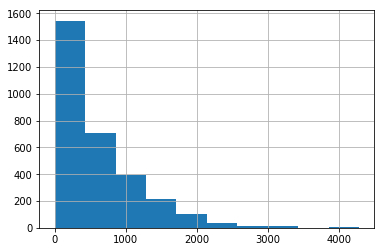

In [255]:
mvmt.hr_bandpwr.hist()

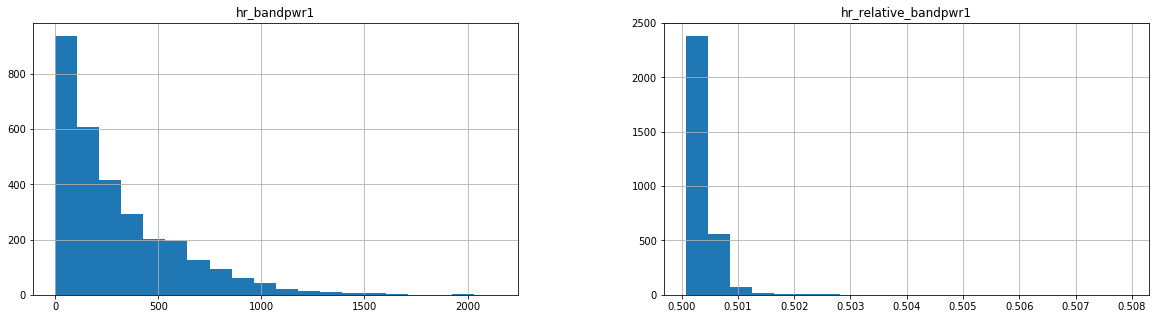

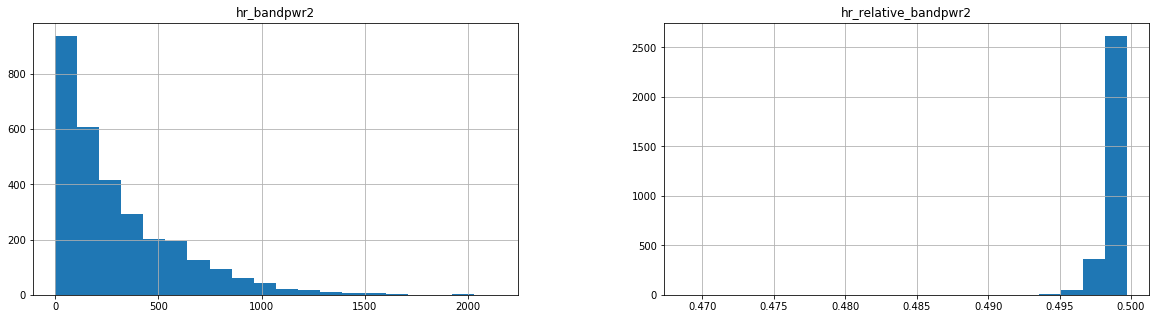

In [253]:
mvmt[['hr_bandpwr1','hr_relative_bandpwr1']].hist(bins=20, figsize=(20,5));
mvmt[['hr_bandpwr2','hr_relative_bandpwr2']].hist(bins=20,  figsize=(20,5));

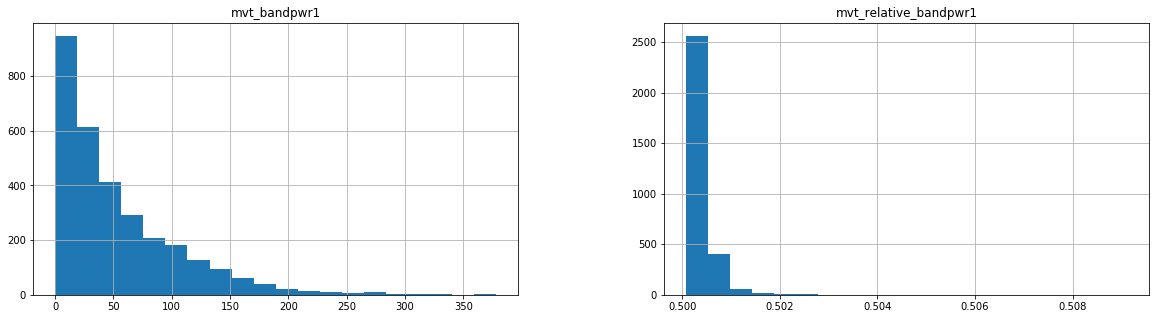

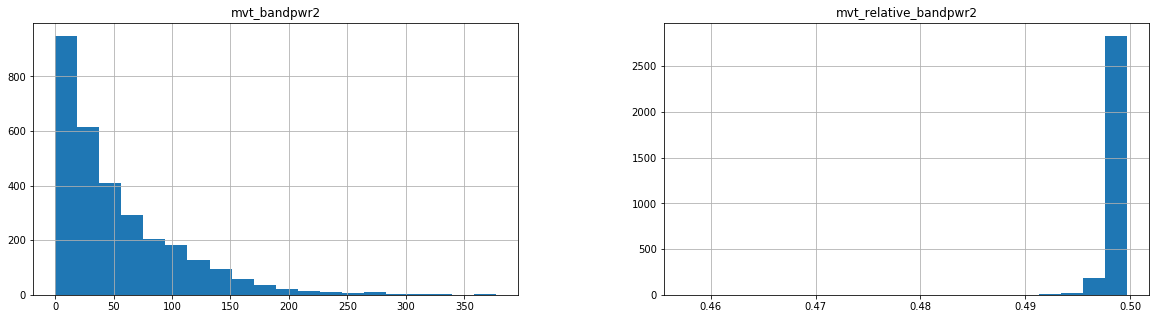

In [254]:
mvmt[['mvt_bandpwr1','mvt_relative_bandpwr1']].hist(bins=20,  figsize=(20,5));
mvmt[['mvt_bandpwr2','mvt_relative_bandpwr2']].hist(bins=20,  figsize=(20,5));

## MVMT Need for Widening
**Dec 6, 2019**

In [258]:
shape = mvmt.shape
patid = mvmt.index.unique().__len__()
print('Shape:', shape)
print('Unique PATIDs:', patid)

Shape: (3076, 30)
Unique PATIDs: 2882


In [256]:
mvmt.reset_index().groupby('patid')['patid'].count().to_frame('cnt').groupby('cnt')['cnt'].count()

cnt
1    2691
2     188
3       3
Name: cnt, dtype: int64

## MVMT Widening Scheme
**Dec 9, 2019**

In [257]:
mvmt1 = mvmt.query("cid=='10'").drop('cid', axis=1)
mvmt1.columns = map(lambda x: 'cid10_'+x, mvmt1.columns)

mvmt2 = mvmt.query("cid=='15'").drop('cid', axis=1)
mvmt2.columns = map(lambda x: 'cid15_'+x, mvmt2.columns)

mvmt3 = mvmt.query("cid=='20'").drop('cid', axis=1)
mvmt3.columns = map(lambda x: 'cid20_'+x, mvmt3.columns)

mvmt_wide = mvmt1.join(mvmt2, how='outer').join(mvmt3, how='outer')
mvmt_wide.head(3)

,cid10_hr_mean,cid10_hr_median,cid10_hr_stddev,cid10_hr_25th,cid10_hr_75th,cid10_hr_min,cid10_hr_max,cid10_mvt_bandpwr1,cid10_mvt_bandpwr2,cid10_mvt_bandpwr3,...,cid20_hr_bandpwr,cid20_hr_relative_bandpwr1,cid20_hr_relative_bandpwr2,cid20_hr_relative_bandpwr3,cid20_hr_relative_bandpwr4,cid20_mvt_bandpwr,cid20_mvt_relative_bandpwr1,cid20_mvt_relative_bandpwr2,cid20_mvt_relative_bandpwr3,cid20_mvt_relative_bandpwr4
patid,,,,,,,,,,,,,,,,,,,,,
S002-BISH-00509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,676.448341,0.500389,0.498790,0.000782,0.000039,117.446213,0.500390,0.498777,0.000783,0.000050
S002-BISH-00674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,617.987575,0.501068,0.496913,0.001970,0.000048,107.298897,0.501071,0.496894,0.001974,0.000061
S002-BISH-00686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1099.910386,0.500274,0.499132,0.000566,0.000029,190.965916,0.500276,0.499123,0.000566,0.000036


## MVMT Wide Nullity

In [262]:
mvmt_nullity = mvmt_wide.isnull().sum().map(lambda x: round(100 * x / len(mvmt_wide), 1)).to_frame('nullity')
mvmt_nullity

,nullity
cid10_hr_mean,97.0
cid10_hr_median,97.0
cid10_hr_stddev,97.0
cid10_hr_25th,97.0
cid10_hr_75th,97.0
cid10_hr_min,97.0
cid10_hr_max,97.0
cid10_mvt_bandpwr1,97.0
cid10_mvt_bandpwr2,97.0
cid10_mvt_bandpwr3,97.0


In [265]:
mvmt_nullity.query('nullity < 87')

,nullity
cid20_hr_mean,9.6
cid20_hr_median,9.6
cid20_hr_stddev,9.6
cid20_hr_25th,9.6
cid20_hr_75th,9.6
cid20_hr_min,9.6
cid20_hr_max,9.6
cid20_mvt_bandpwr1,9.6
cid20_mvt_bandpwr2,9.6
cid20_mvt_bandpwr3,9.6


In [101]:
mvmt.index.unique().__len__()

2882

In [291]:
cid10 = [row[1].nullity for row in mvmt_nullity.reset_index().iterrows() if 'cid10' in row[1]['index']]
[min(cid10), max(cid10)]

[97.0, 97.2]

In [292]:
cid15 = [row[1].nullity for row in mvmt_nullity.reset_index().iterrows() if 'cid15' in row[1]['index']]
[min(cid15), max(cid15)]

[87.8, 89.5]

In [293]:
cid20 = [row[1].nullity for row in mvmt_nullity.reset_index().iterrows() if 'cid20' in row[1]['index']]
[min(cid20), max(cid20)]

[9.6, 30.4]

## MVMT Final Code

In [ ]:
# Reload, if necessary
mvmt = pd.read_csv('../data/raw/maternal_MVMT_monica_EHG_EHG_XFER_240s_Epochs_051818.csv')
mvmt['cid'] = mvmt['Study ID'].apply(lambda x: x.split('-')[-1] if type(x)==str else x)
mvmt['patid'] = mvmt['Study ID'].apply(lambda x: '-'.join(x.split('-')[:-2]))
mvmt.columns = mvmt.columns.to_frame().replace(' ','_',regex=True).iloc[:,0].map(str.lower).values
mvmt.set_index('patid', inplace=True)

mvmt_drop_cols = ['study_id', 'file_name', 'studyid', 'numbersegments', 
                  'meanpercentbad','startsecond', 'endsecond', 'numbersegments__1', 
                  'numberusedpwrcoh', 'numberusedcrscor', ]
mvmt.drop(mvmt_drop_cols, axis=1, inplace=True)

# Heart Rate
mvmt['hr_bandpwr'] = mvmt.hr_bandpwr1 + mvmt.hr_bandpwr2 + mvmt.hr_bandpwr3 + mvmt.hr_bandpwr4
mvmt['hr_relative_bandpwr1'] = mvmt.hr_bandpwr1/mvmt.hr_bandpwr 
mvmt['hr_relative_bandpwr2'] = mvmt.hr_bandpwr2/mvmt.hr_bandpwr 
mvmt['hr_relative_bandpwr3'] = mvmt.hr_bandpwr3/mvmt.hr_bandpwr 
mvmt['hr_relative_bandpwr4'] = mvmt.hr_bandpwr4/mvmt.hr_bandpwr 

# Movement
mvmt['mvt_bandpwr'] = mvmt.mvt_bandpwr1 + mvmt.mvt_bandpwr2 + mvmt.mvt_bandpwr3 + mvmt.mvt_bandpwr4
mvmt['mvt_relative_bandpwr1'] = mvmt.mvt_bandpwr1/mvmt.mvt_bandpwr 
mvmt['mvt_relative_bandpwr2'] = mvmt.mvt_bandpwr2/mvmt.mvt_bandpwr 
mvmt['mvt_relative_bandpwr3'] = mvmt.mvt_bandpwr3/mvmt.mvt_bandpwr 
mvmt['mvt_relative_bandpwr4'] = mvmt.mvt_bandpwr4/mvmt.mvt_bandpwr 

# MVMT Widening
mvmt1 = mvmt.query("cid=='10'").drop('cid', axis=1)
mvmt1.columns = map(lambda x: 'cid10_'+x, mvmt1.columns)

mvmt2 = mvmt.query("cid=='15'").drop('cid', axis=1)
mvmt2.columns = map(lambda x: 'cid15_'+x, mvmt2.columns)

mvmt3 = mvmt.query("cid=='20'").drop('cid', axis=1)
mvmt3.columns = map(lambda x: 'cid20_'+x, mvmt3.columns)

mvmt_wide = mvmt1.join(mvmt2, how='outer').join(mvmt3, how='outer')
mvmt_wide.head(3)

# SENSOR CODE
**Dec 9, 2019**

In [6]:
import pandas as pd

#####################################################
#########            TOI                #############
#####################################################
toi = pd.read_csv('../data/raw/Fetal_Toitu_Physio_Features_Early_Signal_093019.csv')
# Drop "meta data" cols (Dec 10, 2019)
#   Question: Drop these now, or develop file to drop them if we choose to at model time?
#     -- some of these are definite drops (e.g., age, site, filename), but some
#        of the data quality vars might inform a random forest...who knows...
toi_drop_cols = ['F1_hrsegs1', 'F1_totsegs1', 'F1_totsegs4', 'F1_ccsegs4',
                'F1_MVT_PWR_numberSegments.1', 'F1_MVT_PWR_numberUsedPwrCoh',
                'F2_hrsegs1', 'F2_totsegs1', 'F2_totsegs4', 'F2_ccsegs4',
                'F2_MVT_PWR_numberSegments.1', 'F2_MVT_PWR_numberUsedPwrCoh',
                'F31f_hrsegs1', 'F31f_totsegs1', 'F32f_hrsegs1', 'F32f_totsegs1',
                'F3_totsegs4', 'F3_ccsegs4',
                'F3_MVT_PWR_numberSegments.1', 'F3_MVT_PWR_numberUsedPwrCoh']
toi.drop(toi_drop_cols, axis=1, inplace=True)
# Standardize (lowercase, patid index)
toi.columns = map(str.lower, toi.columns)
toi.set_index('patid', inplace=True)
# Remove All-NaN Rows
valid_index = ~(toi.isnull().sum(axis=1) == toi.columns.__len__())
toi = toi[valid_index]
# Drop Duplicated IDs
duplicated_IDs = toi.reset_index().groupby('patid')['patid'].count().to_frame('cnt').query('cnt > 1').index
toi.drop(duplicated_IDs, inplace=True)
# BandPwr
# Despite David recommending defining relative band power for the TOI data, from
#   the var names, I suspect something like that is already done: note that all pwr 
#   quantities in the TOI data have suffixes like 21, 31, or 41, which I suspect mean
#   that these are ratios...
toi_wide = toi  # naming convention for consistency

    

#####################################################
#########           MON RMSSD           #############
#####################################################
rmssd = pd.read_csv('../data/raw/BISH_RMSSD_MONICA_052218_EARLY_SIGNAL2.csv')
# Drop "meta data" cols
#   Question: Drop these now, or develop file to drop them if we choose to at model time?
#     -- some of these are definite drops (e.g., age, site, filename), but some
#        of the data quality vars might inform a random forest...who knows...
rmssd_drop_cols = ['Age', 'Site', 'FileName', 'F1_Total', 'F1_AS Total',
     'F1_QS Total', 'F1_AS Reject', 'F1_QS Reject', 'F1_ASR%',
     'F1_QSR%', 'F2_Study ID +', 'F2_Study ID', 'F2_Study ID.1', 'F2_Study ID.2',
     'F2_Site', 'F2_Total', 'F2_AS Total', 'F2_QS Total', 'F2_AS Reject',
     'F2_QS Reject', 'F2_ASR%', 'F2_QSR%', 'F3_Study ID +', 'F3_Study ID',
     'F3_Study ID.1', 'F3_Study ID.2', 'F3_Site', 'F3_Total',
     'F3_AS Total', 'F3_QS Total', 'F3_AS Reject', 'F3_QS Reject',
     'F3_ASR%', 'F3_QSR%', ]
rmssd.drop(rmssd_drop_cols, axis=1, inplace=True)
# Standardize (lower case, patid index)
rmssd.columns = map(lambda x: x.lower().replace(' ',''), rmssd.columns)
rmssd.set_index('patid', inplace=True)
keep_only_f1 = False
drop_f3 = False
if keep_only_f1:
    f12f_vars = [var for var in rmssd.columns 
           if 'f1' in var and '2f' in var]
    rmssd = rmssd[f12f_vars]
rmssd_wide = rmssd  # naming convention for consistency
# You might choose to drop F3 data at this step, or leave it in for 
#   downstream dropping....




#####################################################
#########             MON MHR           #############
#####################################################
mhr = pd.read_csv('../data/raw/Maternal HR XFER 052318.csv')
mhr.columns = map(str.lower, mhr.columns)
mhr.set_index('patid', inplace=True)
# Drop "meta data" cols
mhr_drop_cols = ['file name', 'numbersegments', 'meanpercentbad',
                'startsecond', 'endsecond', 'numbersegments.1', 
                'numberusedpwrcoh', 'numberusedcrscor']
mhr.drop(mhr_drop_cols, axis=1, inplace=True)
# MHR BAND POWER
mhr['bandpwr'] = mhr.mhr_bandpwr1 + mhr.mhr_bandpwr2 + mhr.mhr_bandpwr3 + mhr.mhr_bandpwr4
mhr['relative_bandpwr1'] = mhr.mhr_bandpwr1/mhr.bandpwr
mhr['relative_bandpwr2'] = mhr.mhr_bandpwr2/mhr.bandpwr
mhr['relative_bandpwr3'] = mhr.mhr_bandpwr3/mhr.bandpwr
# CORRECTION (2020-Jan-10: was accidentally doing bandpwr1/bandpwr for bandpwr4)
mhr['relative_bandpwr4'] = mhr.mhr_bandpwr4/mhr.bandpwr
# Widening
mhr1 = mhr.query("timepoint=='F1'").drop('timepoint', axis=1)
mhr1.columns = map(lambda x: 'f1_'+x, mhr1.columns)
mhr2 = mhr.query("timepoint=='F2'").drop('timepoint', axis=1)
mhr2.columns = map(lambda x: 'f2_'+x, mhr2.columns)
mhr3 = mhr.query("timepoint=='F3'").drop('timepoint', axis=1)
mhr3.columns = map(lambda x: 'f3_'+x, mhr3.columns)
mhr_wide = mhr1.join(mhr2, how='outer').join(mhr3, how='outer')
# You might choose to drop F3 data at this step, or leave it in for 
#   downstream dropping....



#####################################################
#########             MON MVMT          #############
#####################################################
mvmt = pd.read_csv('../data/raw/maternal_MVMT_monica_EHG_EHG_XFER_240s_Epochs_051818.csv')
mvmt['cid'] = mvmt['Study ID'].apply(lambda x: x.split('-')[-1] if type(x)==str else x)
mvmt['patid'] = mvmt['Study ID'].apply(lambda x: '-'.join(x.split('-')[:-2]))
mvmt.columns = mvmt.columns.to_frame().replace(' ','_',regex=True).iloc[:,0].map(str.lower).values
mvmt.set_index('patid', inplace=True)
# Drop "meta data" cols
mvmt_drop_cols = ['study_id', 'file_name', 'studyid', 'numbersegments', 
                  'meanpercentbad','startsecond', 'endsecond', 'numbersegments__1', 
                  'numberusedpwrcoh', 'numberusedcrscor', ]
mvmt.drop(mvmt_drop_cols, axis=1, inplace=True)
# BAND POWER
## Heart Rate
mvmt['hr_bandpwr'] = mvmt.hr_bandpwr1 + mvmt.hr_bandpwr2 + mvmt.hr_bandpwr3 + mvmt.hr_bandpwr4
mvmt['hr_relative_bandpwr1'] = mvmt.hr_bandpwr1/mvmt.hr_bandpwr 
mvmt['hr_relative_bandpwr2'] = mvmt.hr_bandpwr2/mvmt.hr_bandpwr 
mvmt['hr_relative_bandpwr3'] = mvmt.hr_bandpwr3/mvmt.hr_bandpwr 
mvmt['hr_relative_bandpwr4'] = mvmt.hr_bandpwr4/mvmt.hr_bandpwr 
## Movement
mvmt['mvt_bandpwr'] = mvmt.mvt_bandpwr1 + mvmt.mvt_bandpwr2 + mvmt.mvt_bandpwr3 + mvmt.mvt_bandpwr4
mvmt['mvt_relative_bandpwr1'] = mvmt.mvt_bandpwr1/mvmt.mvt_bandpwr 
mvmt['mvt_relative_bandpwr2'] = mvmt.mvt_bandpwr2/mvmt.mvt_bandpwr 
mvmt['mvt_relative_bandpwr3'] = mvmt.mvt_bandpwr3/mvmt.mvt_bandpwr 
mvmt['mvt_relative_bandpwr4'] = mvmt.mvt_bandpwr4/mvmt.mvt_bandpwr 
# MVMT Widening
mvmt1 = mvmt.query("cid=='10'").drop('cid', axis=1)
mvmt1.columns = map(lambda x: 'cid10_'+x, mvmt1.columns)
mvmt2 = mvmt.query("cid=='15'").drop('cid', axis=1)
mvmt2.columns = map(lambda x: 'cid15_'+x, mvmt2.columns)
mvmt3 = mvmt.query("cid=='20'").drop('cid', axis=1)
mvmt3.columns = map(lambda x: 'cid20_'+x, mvmt3.columns)
mvmt_wide = mvmt1.join(mvmt2, how='outer').join(mvmt3, how='outer')
# You might choose to drop F3 data at this step, or leave it in for 
#   downstream dropping....

# All MON
mon_wide_all = rmssd_wide.join(mhr_wide, how='outer').join(mvmt_wide, how='outer')

# All Sensors
sensors = toi_wide.join(mon_wide_all, how='outer')

In [7]:
toi.shape

(6315, 27)

In [8]:
print('Toi Wide Shape:', toi_wide.shape)
print('MON RMSSD Wide Shape:', rmssd_wide.shape)
print('MON MHR Wide Shape:', mhr_wide.shape)
print('MON MVMT Wide Shape:', mvmt_wide.shape)
print('MON All Sensors Shape:', mon_wide_all.shape)
print('MON+TOI Shape:', sensors.shape)

Toi Wide Shape: (6315, 27)
MON RMSSD Wide Shape: (5222, 66)
MON MHR Wide Shape: (3589, 60)
MON MVMT Wide Shape: (2883, 87)
MON All Sensors Shape: (5277, 213)
MON+TOI Shape: (6519, 240)


In [9]:
# Dec 12: Put instrument name in front of col names
toi_wide.columns = map(lambda x: 'sensor_toi_' + x, toi_wide.columns)
rmssd_wide.columns = map(lambda x: 'sensor_monrmssd_' + x, rmssd_wide.columns)
mhr_wide.columns = map(lambda x: 'sensor_monmhr_' + x, mhr_wide.columns)
mvmt_wide.columns = map(lambda x: 'sensor_monmvmt_' + x, mvmt_wide.columns)
# All MON
mon_wide_all = rmssd_wide.join(mhr_wide, how='outer').join(mvmt_wide, how='outer')
# All Sensors
sensors = toi_wide.join(mon_wide_all, how='outer')

In [10]:
# Originally saved on Dec 3, updated on Dec 10.  
# -- New update, Dec 12: put instrument name in front of cols
# -- Updated on Jan 10, 2020:  corrected
#toi_wide.to_csv('../data/interim/toi_20191212_KU.csv')
#rmssd_wide.to_csv('../data/interim/mon-rmssd_20191212_KU.csv')
mhr_wide.to_csv('../data/interim/mon-mhr_20200110_KU.csv')
#mvmt_wide.to_csv('../data/interim/mon-mvmt_20191212_KU.csv')
mon_wide_all.to_csv('../data/interim/mon-all_20200110_KU.csv')
sensors.to_csv('../data/interim/sensors-all_20200110_KU.csv')

# Join Sensor & DemoClinical Data Sets
**Dec 10, 2019**

In [11]:
# Sensor and DemoClinical files have been updated during week of Jan 6-10, 2020
import pandas as pd
sensors = pd.read_csv('../data/interim/sensors-all_20200110_KU.csv')
democlinical = pd.read_csv('../data/interim/democlinical_v4_20200106_KU.csv')

In [12]:
sensors.set_index('patid', inplace=True)
democlinical.set_index('patid', inplace=True)

In [13]:
print('Sensors Shape:', sensors.shape)
print('DemoClinical Shape:', democlinical.shape)

Sensors Shape: (6519, 240)
DemoClinical Shape: (6875, 113)


In [14]:
print('Sensor Patients:', sensors.index.unique().__len__())
print('DemoClinical Patients:', democlinical.index.unique().__len__())

Sensor Patients: 6518
DemoClinical Patients: 6875


In [111]:
print('Patient Intersection:', set(sensors.index).intersection(democlinical.index).__len__())

Patient Intersection: 6489


In [115]:
print('Expected Number of Patients in Final Set:',
     6489 + (6518-6489) + (6875-6489))

Expected Number of Patients in Final Set: 6904


In [116]:
full_set = sensors.join(democlinical, how='outer')

In [117]:
print('Full Set Shape:', full_set.shape)
print('Full Set Patients:', full_set.index.unique().__len__())

Full Set Shape: (6905, 362)
Full Set Patients: 6904


For whatever reason, there still exists patients with more than one record.

In [118]:
full_set.reset_index().groupby('patid')['patid'].count().to_frame('cnt').query('cnt > 1')

,cnt
patid,
S002-BISH-00788,2


In [120]:
full_set.fillna(-999999, inplace=True)
full_set.drop('S002-BISH-00788', inplace=True)

# Full Set Code
**Updated**: 2020-Jan-10

In [15]:
import pandas as pd

# Load (latest sensor files: 20200110)
sensors = pd.read_csv('../data/interim/sensors-all_20200110_KU.csv')
democlinical = pd.read_csv('../data/interim/democlinical_v4_20200106_KU.csv')

# Set Index
sensors.set_index('patid', inplace=True)
democlinical.set_index('patid', inplace=True)

# Join
full_set = sensors.join(democlinical, how='outer')

# Fill NaNs w/ our standard representation
full_set.fillna(-999999, inplace=True)

# Drop repeated patient
full_set.drop('S002-BISH-00788', inplace=True)

# Write
full_set.to_csv('../data/processed/full_set_v4_20200110_KU.csv')

In [27]:
toi_wide.columns

Index(['sensor_toi_f1_hrmean1', 'sensor_toi_f1_hrmed1', 'sensor_toi_f1_hrstd1',
       'sensor_toi_f1_medcc4', 'sensor_toi_f1_medlag4',
       'sensor_toi_f1_mvt_pwr_mvt21', 'sensor_toi_f1_mvt_pwr_mvt31',
       'sensor_toi_f1_mvt_pwr_mvt41', 'sensor_toi_f2_hrmean1',
       'sensor_toi_f2_hrmed1', 'sensor_toi_f2_hrstd1', 'sensor_toi_f2_medcc4',
       'sensor_toi_f2_medlag4', 'sensor_toi_f2_mvt_pwr_mvt21',
       'sensor_toi_f2_mvt_pwr_mvt31', 'sensor_toi_f2_mvt_pwr_mvt41',
       'sensor_toi_f31f_hrmean1', 'sensor_toi_f31f_hrmed1',
       'sensor_toi_f31f_hrstd1', 'sensor_toi_f32f_hrmean1',
       'sensor_toi_f32f_hrmed1', 'sensor_toi_f32f_hrstd1',
       'sensor_toi_f3_medcc4', 'sensor_toi_f3_medlag4',
       'sensor_toi_f3_mvt_pwr_mvt21', 'sensor_toi_f3_mvt_pwr_mvt31',
       'sensor_toi_f3_mvt_pwr_mvt41'],
      dtype='object')